# TIME SERIES MODEL FOR PREDICTING BUDGET BEHAVIOR

Prophet is an open-source time series forecasting tool developed by Facebook. It is designed to handle daily, seasonal, and yearly time series data with missing values and outliers. Prophet is particularly useful for business users and analysts due to its ease of use and interpretability.

# Key Features of Prophet

## Automatic Seasonality Detection:
- Prophet detects **daily, weekly, and yearly seasonality** automatically, but you can also provide custom seasonalities.

## Handling Holidays and Special Events:
- You can add custom holiday effects to improve forecasts.

## Missing Data Handling:
- It gracefully handles missing data without the need for imputation.

## Robust to Outliers:
- The model is resilient to outliers in the data.

## Additive Regression:
- Prophet is an **additive model** that combines components like trend, seasonality, and holidays:

\[
y(t) = g(t) + s(t) + h(t) + \epsilon_t
\]

Where:  
- \( g(t) \): **Trend function** (linear or logistic growth)  
- \( s(t) \): **Seasonality** (daily, weekly, yearly)  
- \( h(t) \): **Holiday effects**  
- \( \epsilon_t \): **Error term**

## User-Friendly Interface:
- Requires minimal parameter tuning compared to traditional methods like ARIMA.

---

# How Prophet Works

## Trend Estimation:
- Two types of growth:  
  - **Linear Trend**: Default for most datasets.  
  - **Logistic Trend**: Useful for data with a known cap or saturation point.

## Seasonality:
- Uses **Fourier series** to model periodic effects like yearly, weekly, or daily seasonality.

## Holiday Effects:
- Allows the inclusion of known holidays or special events that can impact the data.

## Model Fitting:
- Prophet fits the model using an optimization procedure based on **Stan**, a probabilistic programming language.

## Forecast Generation:
- Once the model is fitted, it generates forecasts with **confidence intervals**.

---

# Advantages of Prophet
- Easy to use, with minimal configuration.
- Handles missing values and outliers robustly.
- Works well with irregular time series data.
- Allows domain-specific customizations (e.g., holidays, special trends).
- Generates interpretable forecasts and confidence intervals.

---

# Limitations of Prophet
- Not as flexible for short time series.
- Assumes additive seasonality by default.
- May underperform on very complex datasets compared to advanced deep learning models (e.g., LSTM).
- Not adjust the difference in the currency

# PROPHET MODEL

In [1]:
# Apply the imports first
# Linear algebra
import numpy as np 

# Pandas profiling for Exploratory Data Analysis (EDA)
import pandas_profiling as pp 

# Data processing, CSV file I/O (e.g., pd.read_csv)
import pandas as pd 

# Data visualization
import matplotlib.pyplot as plt # Data visualization
import seaborn as sns # Data visualization
import plotly.express as px # Data visualization
import plotly.graph_objects as go
from scipy.stats import chi2_contingency, norm # Chi-square calculation

# Stocks-related missing information
import yfinance as yf

# Ignoring the warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

# Ranking the stocks
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import optuna
from wordcloud import WordCloud, STOPWORDS # For word cloud generation

# Evaluate if they should be removed
import statsmodels.api as sm

# Time series
import datetime

# Uncomment to install Prophet if not already installed
#!pip install fbprophet --quiet
import plotly.offline as py
py.init_notebook_mode()

# Save model
import pickle

# Apply the "from" statements after the imports

# Evaluate if they should be removed
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from matplotlib.pyplot import figure
from lazypredict.Supervised import LazyClassifier, LazyRegressor
# Ranking the stocks
from plotly.subplots import make_subplots

# Prophet Model Stuff
# Uncomment to install Prophet if not already installed
#!pip install fbprophet --quiet

from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.plot import plot_yearly
from prophet.plot import add_changepoints_to_plot


# Get names of indexes for which column Stock has value No
from pickle import FALSE


# connect with my sql %pip install mysql-connector-python pandas
import mysql.connector


It is important to know how the behavior of the system is in terms of payment and its acquisitions, where the amount is registered with the original modena, the acquisition is defined in pesos, the payment would be in pesos, but if the acquisition is in dollars, then that Payment amount represents dollars.





In [19]:
# Load the CSV file into a DataFrame
df_pagos = pd.read_csv("pagos_moneda_filtro_campos2024.csv", engine="python", sep=',', quotechar='"', error_bad_lines=False)

# Filter out rows where pagos_pk is null
df_pagos = df_pagos[df_pagos['pag_pk'].notna()]


In [20]:
df_pagos.sample(5)

pag_pk pag_fecha_planificada  pag_importe_planificado  \
7136  16185.00         4/3/2019 0:00                 34397.00   
25138 28056.00        7/30/2021 0:00                   902.00   
2457   7030.00       11/10/2017 0:00                 42046.00   
179     103.00         7/5/2012 0:00                 49036.00   
25896 32336.00        9/28/2022 0:00                  1564.00   

        pag_fecha_real  pag_importe_real  pag_confirmar  mon_pk mon_nombre  
7136     4/3/2019 0:00          34397.00           1.00       1      Pesos  
25138   7/30/2021 0:00            902.00           0.00       2     Dlares  
2457   12/22/2017 0:00          42046.00           1.00       1      Pesos  
179      7/5/2012 0:00          86630.00            NaN       1      Pesos  
25896   9/13/2022 0:00           1947.00           1.00       2     Dlares

In [21]:
df_pagos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29704 entries, 0 to 30121
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   pag_pk                   29704 non-null  float64
 1   pag_fecha_planificada    29704 non-null  object 
 2   pag_importe_planificado  29704 non-null  float64
 3   pag_fecha_real           28820 non-null  object 
 4   pag_importe_real         29017 non-null  float64
 5   pag_confirmar            27143 non-null  float64
 6   mon_pk                   29704 non-null  int64  
 7   mon_nombre               29704 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 2.0+ MB


In [22]:
# Seleccionar las columnas a analizar relacionadas con "pagos"
columns_to_analyze_pagos = [
    'pag_pk', 'pag_fecha_planificada', 'pag_importe_planificado', 
    'pag_fecha_real', 'pag_importe_real', 'pag_confirmar', 
    'mon_pk', 'mon_nombre'
]

# Establecer los valores de referencia de registros esperados para cada columna
expected_counts_pagos = {
    'pag_pk': 29704,
    'pag_fecha_planificada': 29704,
    'pag_importe_planificado': 29704,
    'pag_fecha_real': 29704,
    'pag_importe_real': 29704,
    'pag_confirmar': 29704,
    'mon_pk': 29704,
    'mon_nombre': 29704
}

# Calcular la diferencia de registros respecto a los valores esperados
difference_pagos = {col: expected_counts_pagos[col] - df_pagos[col].count() for col in columns_to_analyze_pagos}

# Calcular el porcentaje sobre los valores esperados
percentage_pagos = {col: (df_pagos[col].count() / expected_counts_pagos[col]) * 100 for col in columns_to_analyze_pagos}

# Calcular el porcentaje sobre el total de registros en df_pagos
percentage_total_projects_pagos = {col: (df_pagos[col].count() / 29704) * 100 for col in columns_to_analyze_pagos}

# Calcular el porcentaje con respecto a 'pag_pk'
percentage_with_respect_to_pag_pk = {col: (df_pagos[col].count() / df_pagos['pag_pk'].count()) * 100 for col in columns_to_analyze_pagos}

# Crear un DataFrame con el resultado
result_pagos = pd.DataFrame({
    'Column': columns_to_analyze_pagos,
    'Record Count': [df_pagos[col].count() for col in columns_to_analyze_pagos],
    'Difference from Expected': [difference_pagos[col] for col in columns_to_analyze_pagos],
    'Percentage of Total Expected (%)': [percentage_pagos[col] for col in columns_to_analyze_pagos],
    'Percentage of Total Records (29704) (%)': [percentage_total_projects_pagos[col] for col in columns_to_analyze_pagos],
    'Percentage with respect to pag_pk (%)': [percentage_with_respect_to_pag_pk[col] for col in columns_to_analyze_pagos]
})

# Ajustar el DataFrame para mejor visualización
result_pagos = result_pagos.reset_index(drop=True)
result_pagos.index += 1  # Inicia el índice en 1 en lugar de 0
result_pagos.columns = [
    'Column', 'Record Count', 'Difference from Expected', 
    'Percentage of Total Expected (%)', 'Percentage of Total Records (29704) (%)',
    'Percentage with respect to pag_pk (%)'
]

# Aplicar estilo para mejorar la visualización
styled_result_pagos = result_pagos.style.format({
    'Record Count': '{:,.0f}',
    'Difference from Expected': '{:,.0f}',
    'Percentage of Total Expected (%)': '{:.2f}%',
    'Percentage of Total Records (29704) (%)': '{:.2f}%',
    'Percentage with respect to pag_pk (%)': '{:.2f}%'
}).background_gradient(subset=['Difference from Expected'], cmap='coolwarm')\
   .set_properties(**{
       'border': '1px solid black',
       'padding': '5px',
       'text-align': 'center'
   }).set_table_styles([
       {'selector': 'thead th', 'props': [('background-color', '#4CAF50'), ('color', 'white'), ('text-align', 'center')]},
       {'selector': 'tbody td', 'props': [('text-align', 'center')]}
   ]).set_caption("All Columns, Differences, and Percentages for df_pagos with respect to pag_pk")

# Mostrar la tabla estilizada en Jupyter Notebook
styled_result_pagos


In this case, they would be 8.62% of the records that NaN has and they will be eliminated from the data set, since applying the average would not make sense and replacing it by zero would not either because we would be changing its value.

In [23]:
#Eliminan las filas de esos registros
indexNames = df_pagos[df_pagos['pag_confirmar'].isnull()].index
# Delete these row indexes from dataFrame

df_pagos.drop(indexNames,inplace=True)

In [24]:
df_pagos['pag_confirmar'].isnull().sum()

0

In [25]:
df_pagos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27143 entries, 106 to 30121
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   pag_pk                   27143 non-null  float64
 1   pag_fecha_planificada    27143 non-null  object 
 2   pag_importe_planificado  27143 non-null  float64
 3   pag_fecha_real           26673 non-null  object 
 4   pag_importe_real         26669 non-null  float64
 5   pag_confirmar            27143 non-null  float64
 6   mon_pk                   27143 non-null  int64  
 7   mon_nombre               27143 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 1.9+ MB


From the profile analysis, the data we are going to analyze we want to keep = Payment_Pk, payment_planned_date, payment_planned_amount, payment_actual_date, payment_actual_amount, payment_confirm = 1. In this case we are interested in payment confirm = 1 since these are the payments confirmed by the person responsible for the projects/programs. We discard the unconfirmed ones in order to keep the accurate data.
It is convenient to remember that for the prediction model we are going to project on the actual data.
And an opening by supplier will not be performed.

In [26]:
#Eliminan las filas de esos registros de los no confirmados.
indexNames = df_pagos[df_pagos['pag_confirmar']==0].index
# Delete these row indexes from dataFrame
df_pagos.drop(indexNames,inplace=True)

In [27]:
df_pagos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23659 entries, 106 to 30121
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   pag_pk                   23659 non-null  float64
 1   pag_fecha_planificada    23659 non-null  object 
 2   pag_importe_planificado  23659 non-null  float64
 3   pag_fecha_real           23659 non-null  object 
 4   pag_importe_real         23659 non-null  float64
 5   pag_confirmar            23659 non-null  float64
 6   mon_pk                   23659 non-null  int64  
 7   mon_nombre               23659 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 1.6+ MB


In [88]:
profile = pp.ProfileReport(df_pagos, title = "EDA_Pagos")
profile.to_file(output_file="reporteEDA_Pagos.html") 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
# Calcular el total de registros en df_pagos
total_count = df_pagos['mon_nombre'].count()

# Calcular el conteo de cada moneda
currency_counts = df_pagos['mon_nombre'].value_counts()

# Calcular el porcentaje de cada moneda
currency_percentages = (currency_counts / total_count) * 100

# Crear un DataFrame con los resultados
result_currency = pd.DataFrame({
    'Currency': currency_counts.index,
    'Count': currency_counts.values,
    'Percentage (%)': currency_percentages.values
})

# Filtrar para mostrar solo las monedas relevantes
filtered_result_currency = result_currency[result_currency['Currency'].isin(['Pesos', 'Dlares', 'Euros', 'Unidades Indexadas', 'Unidad Reajustable'])]

# Mostrar la tabla resultante
filtered_result_currency


Currency  Count  Percentage (%)
0               Pesos  15337           64.83
1              Dlares   7999           33.81
2  Unidades Indexadas    315            1.33
3               Euros      7            0.03
4  Unidad Reajustable      1            0.00

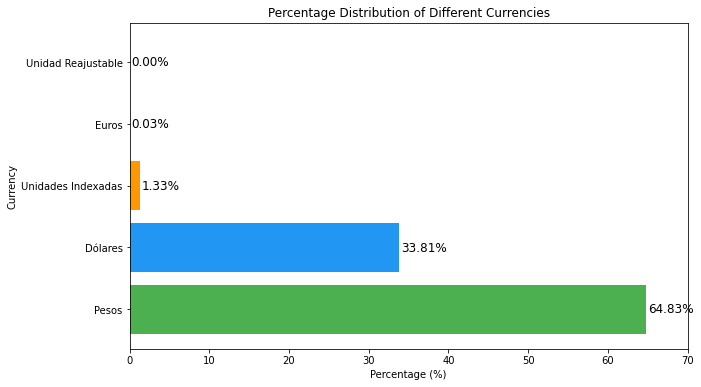

In [30]:
# Updated data with correct values
data = {
    'Currency': ['Pesos', 'Dólares', 'Unidades Indexadas', 'Euros', 'Unidad Reajustable'],
    'Count': [15337, 7999, 315, 7, 1],
    'Percentage': [64.83, 33.81, 1.33, 0.03, 0.00]
}

# Creating a bar plot
plt.figure(figsize=(10, 6))
plt.barh(data['Currency'], data['Percentage'], color=['#4CAF50', '#2196F3', '#FF9800', '#9C27B0', '#673AB7'])

# Adding labels and title
plt.xlabel('Percentage (%)')
plt.ylabel('Currency')
plt.title('Percentage Distribution of Different Currencies')
plt.xlim(0, 70)

# Adding data labels to each bar
for index, value in enumerate(data['Percentage']):
    plt.text(value + 0.2, index, f'{value:.2f}%', va='center', ha='left', fontsize=12)

# Display the plot
plt.show()


64.83% of payments are in pesos. 33.81% are in dollars, and 98.64% of the entire budget is modeled for these two currencies.

In [31]:
df_pagos.describe()

pag_pk  pag_importe_planificado  pag_importe_real  pag_confirmar  \
count 23659.00                 23659.00          23659.00       23659.00   
mean  22955.09                224651.33         215607.63           1.00   
std   13275.84               1995341.94        1073418.99           0.00   
min     125.00              -4306824.00       -4306824.00           1.00   
25%   11501.50                   344.00           1039.00           1.00   
50%   22501.00                  8120.00          10800.00           1.00   
75%   34219.50                 87727.00          88357.50           1.00   
max   49296.00             180000000.00       56212496.00           1.00   

        mon_pk  
count 23659.00  
mean      1.39  
std       0.63  
min       1.00  
25%       1.00  
50%       1.00  
75%       2.00  
max       5.00

In [32]:
# Ensure the column is in datetime format
df_pagos['pag_fecha_real'] = pd.to_datetime(df_pagos['pag_fecha_real'])

# Calculate the minimum and maximum dates
min_date = df_pagos['pag_fecha_real'].min()
max_date = df_pagos['pag_fecha_real'].max()

# Calculate the date range
date_range = max_date - min_date

# Display the results
print(f"Minimum Date: {min_date}")
print(f"Maximum Date: {max_date}")
print(f"Date Range (Duration): {date_range}")

Minimum Date: 2009-01-31 00:00:00
Maximum Date: 2024-08-15 00:00:00
Date Range (Duration): 5675 days 00:00:00


The Prophet model does not inherently account for currency-related differences. Therefore, I adjusted the values in pesos for inflation and converted them into dollars. I used the historical exchange rates provided on this page, applying an annual average exchange rate, as monthly variations are minimal and do not significantly impact the results.

The DataFrame will now have two additional columns:

pag_importe_real_convert: Values from pag_importe_real converted to dollars.
pag_importe_planificado_convert: Values from pag_importe_planificado converted to dollars.

In [33]:
import pandas as pd 

# Exchange rate table
exchange_rate = {
    2024: 40.03,
    2023: 38.84,
    2022: 41.13,
    2021: 43.56,
    2020: 41.99,
    2019: 35.22,
    2018: 30.71,
    2017: 28.66,
    2016: 30.14,
    2015: 27.31
}

# Ensure the 'pag_fecha_real' column is in datetime format
df_pagos['pag_fecha_real'] = pd.to_datetime(df_pagos['pag_fecha_real'])

# Function to calculate the converted amount
def convert_to_dollars(row, column_name):
    if row['mon_pk'] == 1:  # Check if currency is pesos
        year = row['pag_fecha_real'].year
        if year in exchange_rate:  # Ensure year exists in the exchange rate table
            tc = exchange_rate[year]  # Get the exchange rate for the year
            return row[column_name] / tc  # Convert pesos to dollars
        else:
            return row[column_name]  # Default to no conversion if year not found
    else:
        return row[column_name]  # If not pesos, keep the same value

# Apply the conversion logic to 'pag_importe_real' and 'pag_importe_planificado'
df_pagos['pag_importe_real_convert'] = df_pagos.apply(lambda row: convert_to_dollars(row, 'pag_importe_real'), axis=1)
df_pagos['pag_importe_planificado_convert'] = df_pagos.apply(lambda row: convert_to_dollars(row, 'pag_importe_planificado'), axis=1)

# Display the resulting DataFrame
print(df_pagos)



       pag_pk pag_fecha_planificada  pag_importe_planificado pag_fecha_real  \
106    125.00       11/23/2012 0:00                 25205.00     2012-11-23   
107    427.00       12/28/2012 0:00                 25205.00     2012-12-28   
108    428.00        5/10/2013 0:00                 17644.00     2013-05-10   
109    429.00        6/21/2013 0:00                 17644.00     2013-06-21   
110    430.00        7/26/2013 0:00                 40328.00     2013-07-26   
...       ...                   ...                      ...            ...   
30082 9861.00        6/16/2017 0:00                     0.00     2018-01-22   
30083 9862.00         6/7/2017 0:00                     0.00     2018-01-22   
30084 9863.00        5/30/2017 0:00                     0.00     2018-01-22   
30105 3451.00        7/21/2015 0:00                438538.00     2015-07-15   
30121 3467.00        7/21/2015 0:00                     0.00     2015-07-21   

       pag_importe_real  pag_confirmar  mon_pk     

In [34]:
df_pagos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23659 entries, 106 to 30121
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   pag_pk                           23659 non-null  float64       
 1   pag_fecha_planificada            23659 non-null  object        
 2   pag_importe_planificado          23659 non-null  float64       
 3   pag_fecha_real                   23659 non-null  datetime64[ns]
 4   pag_importe_real                 23659 non-null  float64       
 5   pag_confirmar                    23659 non-null  float64       
 6   mon_pk                           23659 non-null  int64         
 7   mon_nombre                       23659 non-null  object        
 8   pag_importe_real_convert         23659 non-null  float64       
 9   pag_importe_planificado_convert  23659 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
me

In [35]:
import plotly.express as px

# Filter the DataFrame for currencies 1 and 2
df_filtered = df_pagos[df_pagos['mon_pk'].isin([1, 2])]

# Create the box plot
fig = px.box(df_filtered, y="pag_importe_real_convert", title="Real Payment Amounts (Currencies 1 and 2)")
fig.show()


The plot shows many outliers with very large values (up to 50+ million), suggesting extreme payment amounts in the dataset.
These outliers are far beyond the typical range of most data points. For that reason prpohet is appropiate to manage outliers.

In [18]:
import plotly.express as px

# Filter the DataFrame for currencies 1 and 2
df_filtered = df_pagos[df_pagos['mon_pk'].isin([1, 2])]

# Create the box plot
fig = px.box(df_filtered, y="pag_importe_planificado_convert", title="Planning Payment Amounts (Currencies 1 and 2)")
fig.show()


Legitimate Large Planned Payments:
Some projects or planned payments might involve significantly higher amounts, which are reflected as outliers.
Data Entry Errors:
Verify if extremely large planned payment amounts are valid or caused by input errors.
Skewed Payment Distributions:
It's common for financial datasets to have a small number of large transactions and many smaller ones.

In [36]:
df_indice_recet= df_pagos.reset_index()

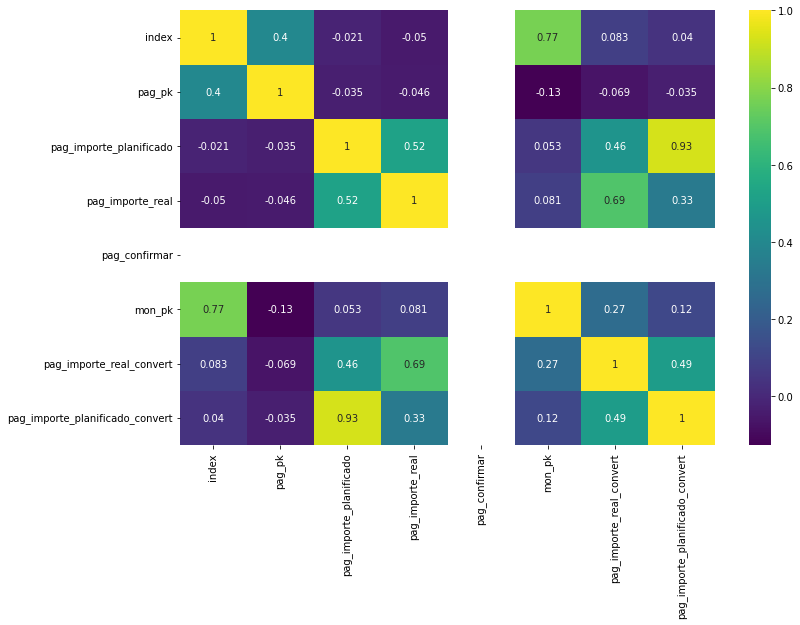

In [37]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_indice_recet.corr(), annot=True, cmap='viridis')
plt.show()

In [38]:
# Check unique values in 'mon_nombre' column to see available currencies
unique_currencies = df_pagos['mon_pk'].unique()

# Display the currencies
print("Unique Currencies in df_pagos:")
for currency in unique_currencies:
    print(f"- {currency}")


Unique Currencies in df_pagos:
- 1
- 2
- 3
- 4
- 5


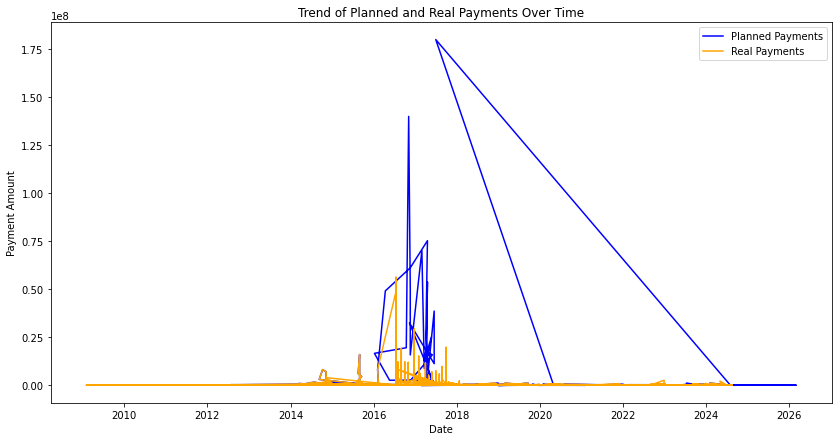

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert date columns to datetime
df_pagos['pag_fecha_planificada'] = pd.to_datetime(df_pagos['pag_fecha_planificada'])
df_pagos['pag_fecha_real'] = pd.to_datetime(df_pagos['pag_fecha_real'])

# Plot planned payments over time
plt.figure(figsize=(14, 7))
plt.plot(df_pagos['pag_fecha_planificada'], df_pagos['pag_importe_planificado_convert'], label='Planned Payments', color='blue')
plt.plot(df_pagos['pag_fecha_real'], df_pagos['pag_importe_real_convert'], label='Real Payments', color='orange')
plt.xlabel('Date')
plt.ylabel('Payment Amount')
plt.title('Trend of Planned and Real Payments Over Time')
plt.legend()
plt.show()


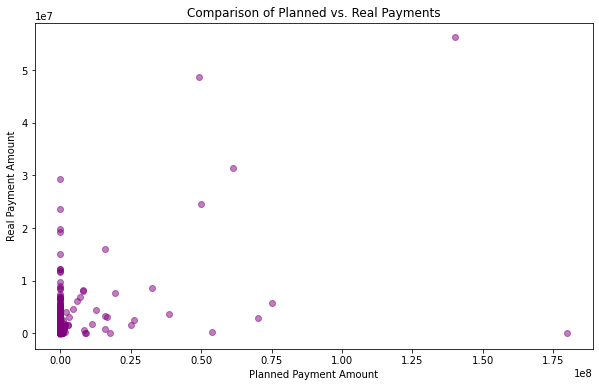

<Figure size 720x432 with 0 Axes>

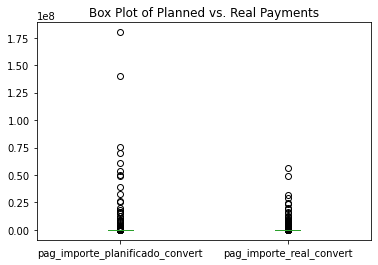

In [40]:
# Scatter plot comparing planned and real payments
plt.figure(figsize=(10, 6))
plt.scatter(df_pagos['pag_importe_planificado_convert'], df_pagos['pag_importe_real_convert'], alpha=0.5, color='purple')
plt.xlabel('Planned Payment Amount')
plt.ylabel('Real Payment Amount')
plt.title('Comparison of Planned vs. Real Payments')
plt.show()

# Box plot for planned vs. real payments
plt.figure(figsize=(10, 6))
df_pagos[['pag_importe_planificado_convert', 'pag_importe_real_convert']].plot(kind='box')
plt.title('Box Plot of Planned vs. Real Payments')
plt.show()



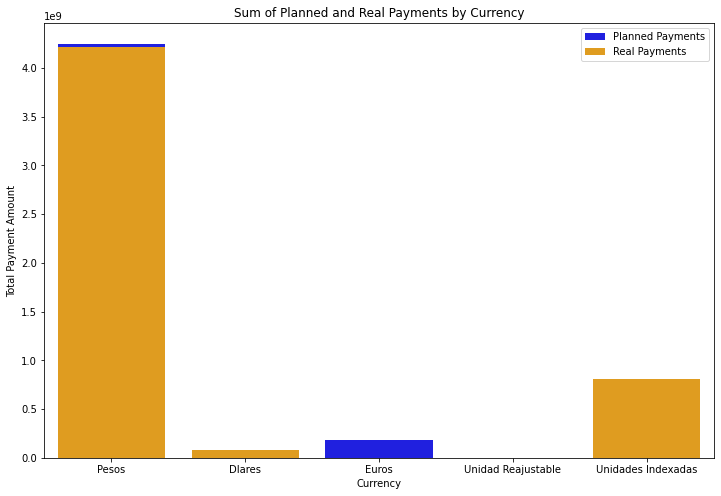

In [41]:
import seaborn as sns

# Grouped bar plot by currency
plt.figure(figsize=(12, 8))
sns.barplot(x='mon_nombre', y='pag_importe_planificado', data=df_pagos, estimator=sum, ci=None, label='Planned Payments', color='blue')
sns.barplot(x='mon_nombre', y='pag_importe_real', data=df_pagos, estimator=sum, ci=None, label='Real Payments', color='orange')
plt.title('Sum of Planned and Real Payments by Currency')
plt.ylabel('Total Payment Amount')
plt.xlabel('Currency')
plt.legend()
plt.show()


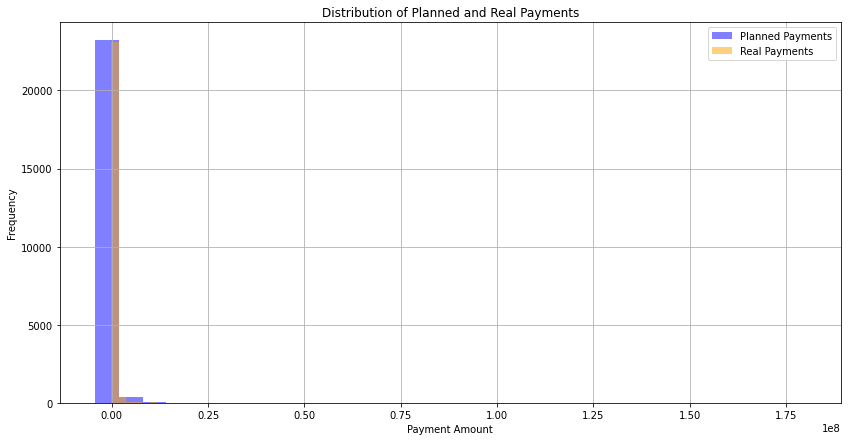

In [42]:
# Histograms for payment distributions
plt.figure(figsize=(14, 7))
df_pagos['pag_importe_planificado'].hist(bins=30, alpha=0.5, label='Planned Payments', color='blue')
df_pagos['pag_importe_real'].hist(bins=30, alpha=0.5, label='Real Payments', color='orange')
plt.xlabel('Payment Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Planned and Real Payments')
plt.legend()
plt.show()


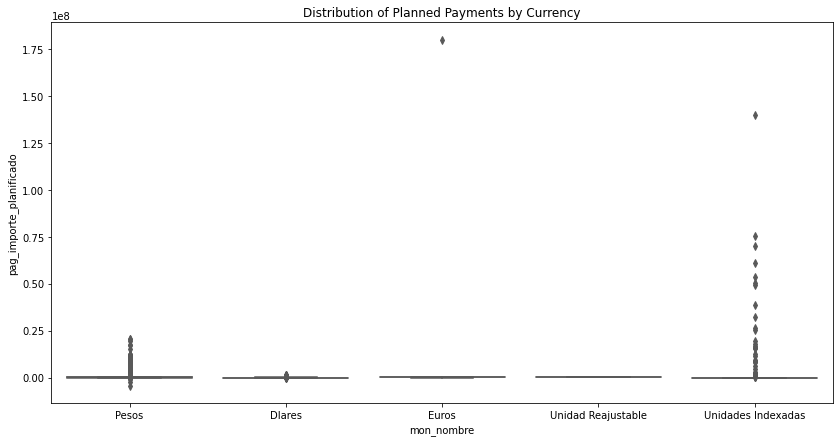

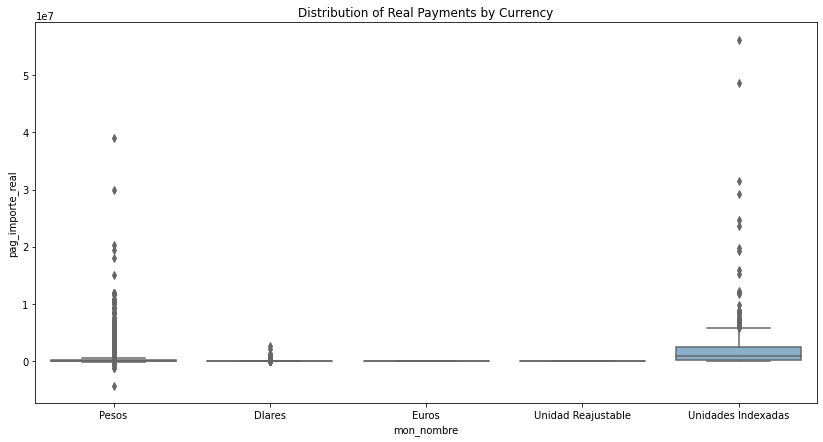

In [43]:
# Box plots segmented by currency
plt.figure(figsize=(14, 7))
sns.boxplot(x='mon_nombre', y='pag_importe_planificado', data=df_pagos, palette='Set2')
plt.title('Distribution of Planned Payments by Currency')
plt.show()

plt.figure(figsize=(14, 7))
sns.boxplot(x='mon_nombre', y='pag_importe_real', data=df_pagos, palette='Set3')
plt.title('Distribution of Real Payments by Currency')
plt.show()


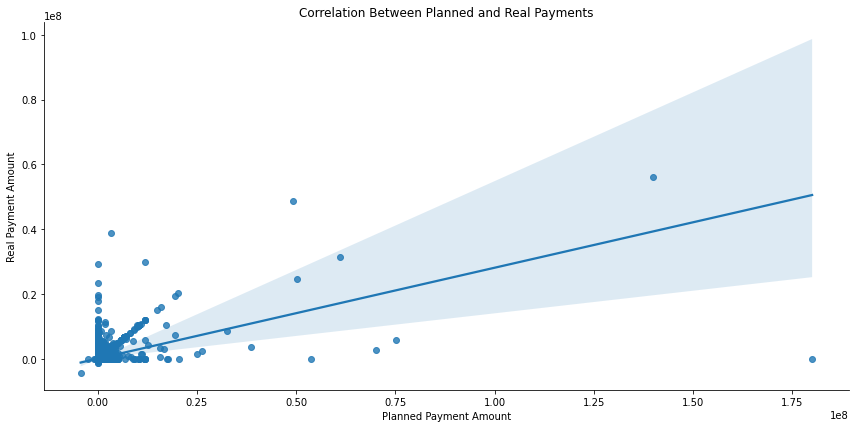

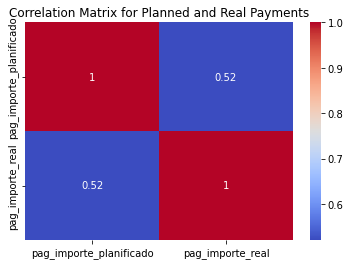

In [44]:
# Scatter plot with trend line
sns.lmplot(x='pag_importe_planificado', y='pag_importe_real', data=df_pagos, aspect=2, height=6)
plt.xlabel('Planned Payment Amount')
plt.ylabel('Real Payment Amount')
plt.title('Correlation Between Planned and Real Payments')
plt.show()

# Correlation matrix
correlation_matrix = df_pagos[['pag_importe_planificado', 'pag_importe_real']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Planned and Real Payments')
plt.show()


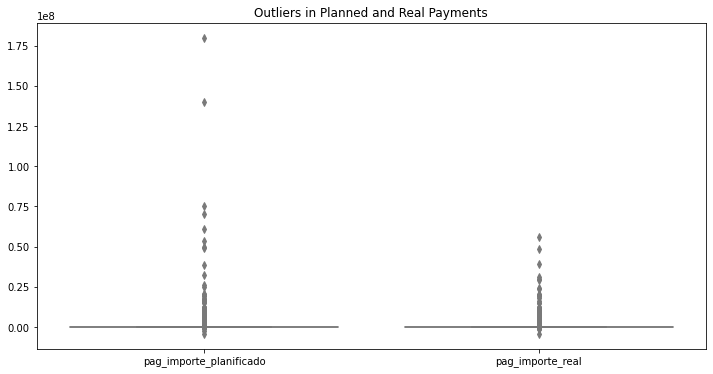

In [45]:
# Box plots to detect outliers in planned and real payments
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_pagos[['pag_importe_planificado', 'pag_importe_real']], palette='coolwarm')
plt.title('Outliers in Planned and Real Payments')
plt.show()


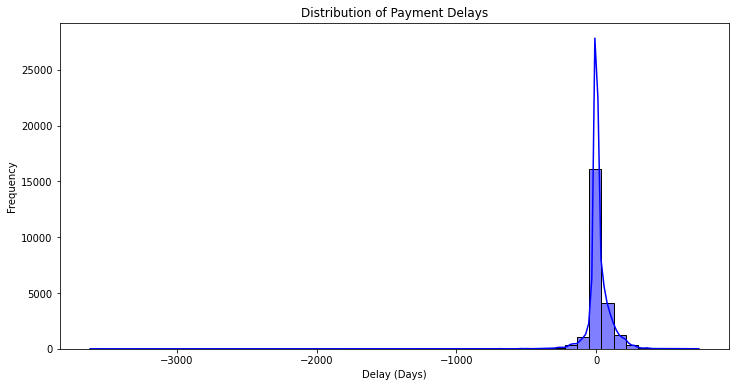

In [46]:
# Calculate delay between planned and real payment dates
df_pagos['delay_days'] = (pd.to_datetime(df_pagos['pag_fecha_real']) - pd.to_datetime(df_pagos['pag_fecha_planificada'])).dt.days

# Plot the distribution of delays
plt.figure(figsize=(12, 6))
sns.histplot(df_pagos['delay_days'], bins=50, kde=True, color='blue')
plt.title('Distribution of Payment Delays')
plt.xlabel('Delay (Days)')
plt.ylabel('Frequency')
plt.show()


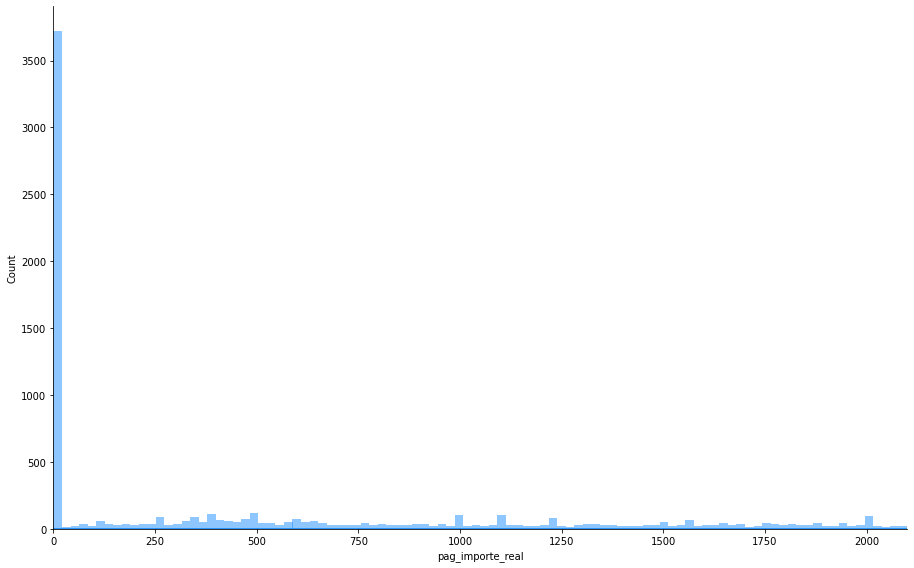

In [47]:
d2 = sns.displot(data=df_indice_recet, x='pag_importe_real', kde=True, height=8, aspect=1.6, bins=100, binrange=(0, 2100), color='dodgerblue')
d2.set(xlabel='pag_importe_real')
plt.xlim(0, 2100)
plt.show()

In [48]:
#Cambio de los tipo objetos a tipo fecha 
df_pagos['pag_fecha_planificada'] = pd.to_datetime(df_pagos['pag_fecha_planificada'])
df_pagos['pag_fecha_real'] = pd.to_datetime(df_pagos['pag_fecha_real'])

df_pagos.head()

pag_pk pag_fecha_planificada  pag_importe_planificado pag_fecha_real  \
106  125.00            2012-11-23                 25205.00     2012-11-23   
107  427.00            2012-12-28                 25205.00     2012-12-28   
108  428.00            2013-05-10                 17644.00     2013-05-10   
109  429.00            2013-06-21                 17644.00     2013-06-21   
110  430.00            2013-07-26                 40328.00     2013-07-26   

     pag_importe_real  pag_confirmar  mon_pk mon_nombre  \
106          25205.00           1.00       1      Pesos   
107          25205.00           1.00       1      Pesos   
108          17644.00           1.00       1      Pesos   
109          17644.00           1.00       1      Pesos   
110          40328.00           1.00       1      Pesos   

     pag_importe_real_convert  pag_importe_planificado_convert  delay_days  
106                  25205.00                         25205.00           0  
107                  25205.00                         25205.00           0  
108                  17644.00                         17644.00           0  
109                  17644.00                         17644.00           0  
110                  40328.00                         40328.00           0

In [49]:
sns.set_style('darkgrid')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (20, 9)
plt.rcParams['figure.facecolor'] = '#00000000'
plt.rcParams['lines.linewidth'] = 2
# plt.style.use('fivethirtyeight')

In [50]:
df_pagos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23659 entries, 106 to 30121
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   pag_pk                           23659 non-null  float64       
 1   pag_fecha_planificada            23659 non-null  datetime64[ns]
 2   pag_importe_planificado          23659 non-null  float64       
 3   pag_fecha_real                   23659 non-null  datetime64[ns]
 4   pag_importe_real                 23659 non-null  float64       
 5   pag_confirmar                    23659 non-null  float64       
 6   mon_pk                           23659 non-null  int64         
 7   mon_nombre                       23659 non-null  object        
 8   pag_importe_real_convert         23659 non-null  float64       
 9   pag_importe_planificado_convert  23659 non-null  float64       
 10  delay_days                       23659 non-null  int64  

In [51]:
df_pagos_DP=df_pagos

In [52]:

dfi=df_pagos.set_index('pag_fecha_real', drop=True, append=False, inplace=False, verify_integrity=False)
dfi

pag_pk pag_fecha_planificada  pag_importe_planificado  \
pag_fecha_real                                                          
2012-11-23      125.00            2012-11-23                 25205.00   
2012-12-28      427.00            2012-12-28                 25205.00   
2013-05-10      428.00            2013-05-10                 17644.00   
2013-06-21      429.00            2013-06-21                 17644.00   
2013-07-26      430.00            2013-07-26                 40328.00   
...                ...                   ...                      ...   
2018-01-22     9861.00            2017-06-16                     0.00   
2018-01-22     9862.00            2017-06-07                     0.00   
2018-01-22     9863.00            2017-05-30                     0.00   
2015-07-15     3451.00            2015-07-21                438538.00   
2015-07-21     3467.00            2015-07-21                     0.00   

                pag_importe_real  pag_confirmar  mon_pk          mon_nombre  \
pag_fecha_real                                                                
2012-11-23              25205.00           1.00       1               Pesos   
2012-12-28              25205.00           1.00       1               Pesos   
2013-05-10              17644.00           1.00       1               Pesos   
2013-06-21              17644.00           1.00       1               Pesos   
2013-07-26              40328.00           1.00       1               Pesos   
...                          ...            ...     ...                 ...   
2018-01-22             144163.00           1.00       5  Unidades Indexadas   
2018-01-22             457457.00           1.00       5  Unidades Indexadas   
2018-01-22             191963.00           1.00       5  Unidades Indexadas   
2015-07-15             138538.00           1.00       5  Unidades Indexadas   
2015-07-21             300000.00           1.00       5  Unidades Indexadas   

                pag_importe_real_convert  pag_importe_planificado_convert  \
pag_fecha_real                                                              
2012-11-23                      25205.00                         25205.00   
2012-12-28                      25205.00                         25205.00   
2013-05-10                      17644.00                         17644.00   
2013-06-21                      17644.00                         17644.00   
2013-07-26                      40328.00                         40328.00   
...                                  ...                              ...   
2018-01-22                     144163.00                             0.00   
2018-01-22                     457457.00                             0.00   
2018-01-22                     191963.00                             0.00   
2015-07-15                     138538.00                        438538.00   
2015-07-21                     300000.00                             0.00   

                delay_days  
pag_fecha_real              
2012-11-23               0  
2012-12-28               0  
2013-05-10               0  
2013-06-21               0  
2013-07-26               0  
...                    ...  
2018-01-22             220  
2018-01-22             229  
2018-01-22             237  
2015-07-15              -6  
2015-07-21               0  

[23659 rows x 10 columns]

In [53]:
pesos =dfi.query("mon_nombre == 'Pesos'")
dolares = dfi.query("mon_nombre == 'Dlares'")
euros = dfi.query("mon_nombre == 'Euro'")

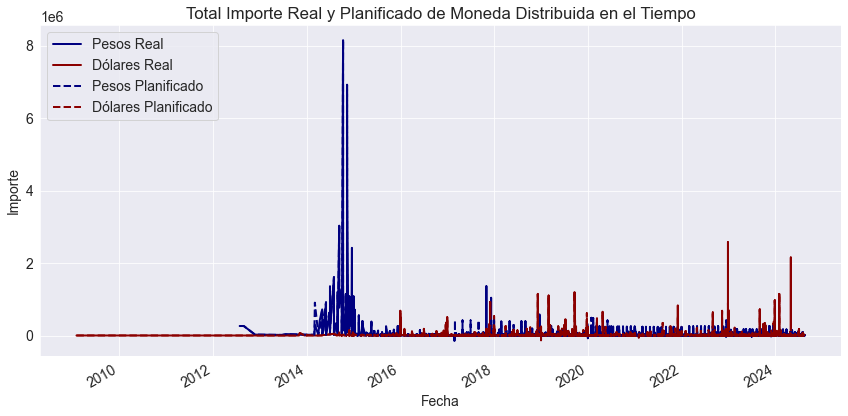

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize=(12, 6))

# Usar colores y estilos de línea distintivos
pesos['pag_importe_real_convert'].plot(ax=ax, color='navy', linestyle='-', label='Pesos Real')
dolares['pag_importe_real_convert'].plot(ax=ax, color='darkred', linestyle='-', label='Dólares Real')


pesos['pag_importe_planificado_convert'].plot(ax=ax, color='navy', linestyle='--', label='Pesos Planificado')
dolares['pag_importe_planificado_convert'].plot(ax=ax, color='darkred', linestyle='--', label='Dólares Planificado')


ax.set_title('Total Importe Real y Planificado de Moneda Distribuida en el Tiempo')
ax.set_xlabel('Fecha')
ax.set_ylabel('Importe')
ax.legend(loc='upper left')
ax.grid(True)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()


It is observed that election years and seasonality have an impact, with the highest execution being concentrated in December at the end of the year.

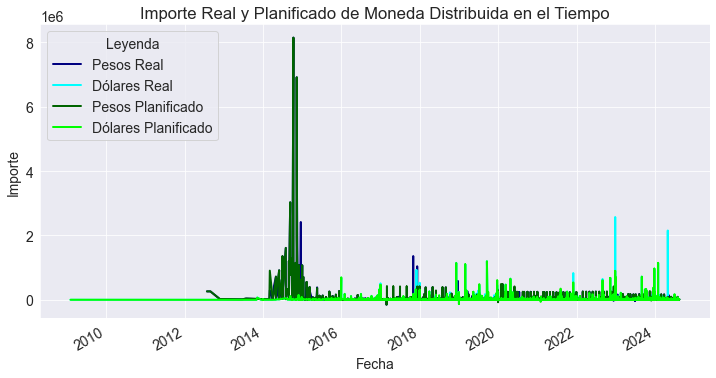

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que 'pesos' y 'dolares' ya están definidos y contienen los datos adecuados
fig, ax = plt.subplots(figsize=(12, 6))

# Usar una paleta de colores más distintiva
pesos['pag_importe_real_convert'].plot(ax=ax, color='navy', label='Pesos Real')
dolares['pag_importe_real_convert'].plot(ax=ax, color='cyan', label='Dólares Real')
pesos['pag_importe_planificado_convert'].plot(ax=ax, color='darkgreen', label='Pesos Planificado')
dolares['pag_importe_planificado_convert'].plot(ax=ax, color='lime', label='Dólares Planificado')

ax.set_title('Importe Real y Planificado de Moneda Distribuida en el Tiempo')
ax.set_xlabel('Fecha')
ax.set_ylabel('Importe')
ax.legend(title='Leyenda', loc='upper left')
ax.grid(True)
ax.set_axisbelow(True)

plt.show()



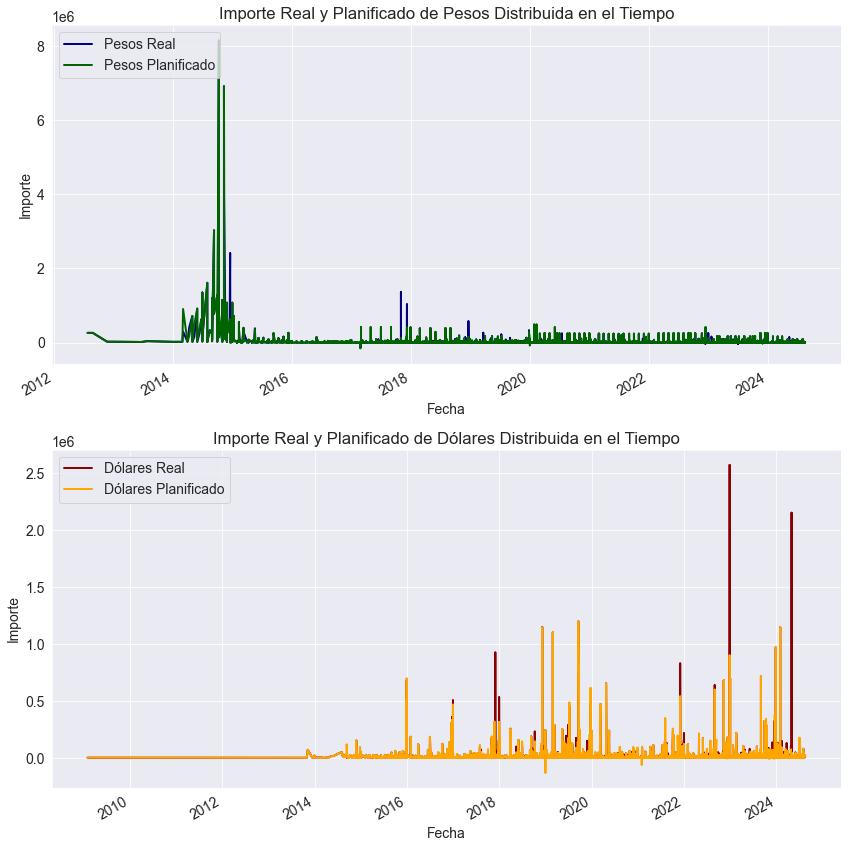

In [57]:
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que 'pesos' y 'dolares' ya están definidos y contienen los datos adecuados
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Gráfico para pesos
pesos['pag_importe_real_convert'].plot(ax=ax1, color='navy', label='Pesos Real')
pesos['pag_importe_planificado_convert'].plot(ax=ax1, color='darkgreen', label='Pesos Planificado')
ax1.set_title('Importe Real y Planificado de Pesos Distribuida en el Tiempo')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Importe')
ax1.legend(loc='upper left')
ax1.grid(True)

# Gráfico para dólares con nuevos colores
dolares['pag_importe_real_convert'].plot(ax=ax2, color='darkred', label='Dólares Real')
dolares['pag_importe_planificado_convert'].plot(ax=ax2, color='orange', label='Dólares Planificado')
ax2.set_title('Importe Real y Planificado de Dólares Distribuida en el Tiempo')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Importe')
ax2.legend(loc='upper left')
ax2.grid(True)

plt.tight_layout()
plt.show()



The planned value can be observed in contrast with the actual value, where it can be seen that 2019 is an election year, where there is no allocated budget, which affects the time to develop projects.

In [58]:
df_pagos=dfi.reset_index()

In [59]:
df_pagos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23659 entries, 0 to 23658
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   pag_fecha_real                   23659 non-null  datetime64[ns]
 1   pag_pk                           23659 non-null  float64       
 2   pag_fecha_planificada            23659 non-null  datetime64[ns]
 3   pag_importe_planificado          23659 non-null  float64       
 4   pag_importe_real                 23659 non-null  float64       
 5   pag_confirmar                    23659 non-null  float64       
 6   mon_pk                           23659 non-null  int64         
 7   mon_nombre                       23659 non-null  object        
 8   pag_importe_real_convert         23659 non-null  float64       
 9   pag_importe_planificado_convert  23659 non-null  float64       
 10  delay_days                       23659 non-null  int64    

In [60]:
df_pagos.sample(2)

pag_fecha_real   pag_pk pag_fecha_planificada  pag_importe_planificado  \
10897     2022-09-16 31189.00            2022-08-30                  7482.00   
8992      2021-11-19 29705.00            2021-09-20                     0.00   

       pag_importe_real  pag_confirmar  mon_pk mon_nombre  \
10897          10566.00           1.00       1      Pesos   
8992          224432.00           1.00       1      Pesos   

       pag_importe_real_convert  pag_importe_planificado_convert  delay_days  
10897                    256.89                           181.91          17  
8992                    5152.25                             0.00          60

# PESOS CONVERT DOLARS AND DOLARES BUDGET PREDICTION MODEL

In [61]:
# Keep only rows where 'mon_pk' is 1 or 2
df_pagos = df_pagos[df_pagos['mon_pk'].isin([1, 2])]

# Reset the index after filtering
df_pagos.reset_index(drop=True, inplace=True)

# Display the updated DataFrame
print(df_pagos)


      pag_fecha_real   pag_pk pag_fecha_planificada  pag_importe_planificado  \
0         2012-11-23   125.00            2012-11-23                 25205.00   
1         2012-12-28   427.00            2012-12-28                 25205.00   
2         2013-05-10   428.00            2013-05-10                 17644.00   
3         2013-06-21   429.00            2013-06-21                 17644.00   
4         2013-07-26   430.00            2013-07-26                 40328.00   
...              ...      ...                   ...                      ...   
23331     2024-07-16 48814.00            2024-07-31                    68.00   
23332     2024-02-29 48603.00            2024-07-26                     0.00   
23333     2024-06-21 48808.00            2024-06-17                  2980.00   
23334     2024-06-21 48810.00            2024-06-17                   362.00   
23335     2024-07-16 48815.00            2024-07-31                     8.00   

       pag_importe_real  pag_confirmar 

In [62]:
df_pagos.sample(5)

pag_fecha_real   pag_pk pag_fecha_planificada  pag_importe_planificado  \
15472     2014-11-27  1197.00            2014-11-27                  1868.90   
9941      2021-07-13 27988.00            2021-04-12                     0.00   
3353      2018-11-30 11474.00            2018-11-30                     0.00   
22283     2023-12-12 44828.00            2023-12-14                     0.00   
19040     2019-07-31 16002.00            2019-07-31                130000.00   

       pag_importe_real  pag_confirmar  mon_pk mon_nombre  \
15472           1868.90           1.00       2     Dlares   
9941           58745.00           1.00       1      Pesos   
3353           62525.00           1.00       1      Pesos   
22283           2139.00           1.00       2     Dlares   
19040         123680.00           1.00       2     Dlares   

       pag_importe_real_convert  pag_importe_planificado_convert  delay_days  
15472                   1868.90                          1868.90           0  
9941                    1348.60                             0.00          92  
3353                    2035.98                             0.00           0  
22283                   2139.00                             0.00          -2  
19040                 123680.00                        130000.00           0

In [63]:
pagos_modelo_pesos=df_pagos.drop(['pag_pk','pag_fecha_planificada','pag_importe_planificado','pag_confirmar','mon_pk','mon_nombre','pag_importe_real','pag_importe_planificado_convert','delay_days'],axis=1)
pagos_modelo_pesos.shape

(23336, 2)

In [64]:
pagos_modelo_pesos.sample(5)

pag_fecha_real  pag_importe_real_convert
2722      2018-10-17                    598.47
4167      2018-12-21                   2844.15
12964     2023-09-12                   1057.26
15793     2015-11-25                   1104.00
12589     2022-11-30                    103.16

In [65]:
# Total number of rows in the dataset
total_rows = pagos_modelo_pesos.shape[0]

# Count rows where 'pag_importe_real_convert' is 0.0
count_zeros = pagos_modelo_pesos[pagos_modelo_pesos['pag_importe_real_convert'] == 0.0].shape[0]

# Calculate the percentage
percentage_zeros = (count_zeros / total_rows) * 100

# Display the results
print(f"Total rows in the dataset: {total_rows}")
print(f"Rows with 'pag_importe_real_convert' equal to 0.0: {count_zeros}")
print(f"Percentage of rows with 'pag_importe_real_convert' equal to 0.0: {percentage_zeros:.2f}%")



Total rows in the dataset: 23336
Rows with 'pag_importe_real_convert' equal to 0.0: 3694
Percentage of rows with 'pag_importe_real_convert' equal to 0.0: 15.83%


They Represent Real Zero Payments:

Leave the values as 0.0. Prophet can handle zeros as part of the cash flow.

In [66]:
pagos_modelo_pesos.sort_values(['pag_fecha_real', 'pag_importe_real_convert'],ascending=False) 
pagos_modelo_pesos

pag_fecha_real  pag_importe_real_convert
0         2012-11-23                  25205.00
1         2012-12-28                  25205.00
2         2013-05-10                  17644.00
3         2013-06-21                  17644.00
4         2013-07-26                  40328.00
...              ...                       ...
23331     2024-07-16                     68.00
23332     2024-02-29                   1260.00
23333     2024-06-21                   2980.00
23334     2024-06-21                    362.00
23335     2024-07-16                      8.00

[23336 rows x 2 columns]

In [67]:
pagos_modelo_pesos.head(5)

pag_fecha_real  pag_importe_real_convert
0     2012-11-23                  25205.00
1     2012-12-28                  25205.00
2     2013-05-10                  17644.00
3     2013-06-21                  17644.00
4     2013-07-26                  40328.00

In [68]:
pagos_modelo_pesos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23336 entries, 0 to 23335
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   pag_fecha_real            23336 non-null  datetime64[ns]
 1   pag_importe_real_convert  23336 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 364.8 KB


In [69]:
pagos_modelo_pesos['pag_importe_real_convert'].max()

8147864.0

In [70]:
pagos_modelo_pesos['pag_importe_real_convert'].mean()

10344.074283777269

In [71]:
pagos_modelo_pesos['pag_importe_real_convert'].min()

-150272.99371946964

Refunds or Reimbursements could be negative I amd going to investigate more the negative values.

In [72]:
negative_values = pagos_modelo_pesos[pagos_modelo_pesos['pag_importe_real_convert'] < 0]
print(negative_values)
print(f"Total negative values: {negative_values.shape[0]}")


      pag_fecha_real  pag_importe_real_convert
1807      2017-02-24                -150272.99
4145      2018-12-31                 -12928.07
4173      2018-12-31                  -2844.15
5183      2019-02-28                   -237.59
5184      2019-03-29                   -907.47
5185      2019-03-29                   -206.73
5194      2019-02-28                    -52.27
5195      2019-03-29                   -199.63
5196      2019-03-29                    -45.46
5924      2019-09-05                   -324.25
6183      2020-02-28                  -3699.45
7956      2022-04-08                  -5573.64
11497     2022-01-26                  -4169.61
11560     2023-06-30                 -30270.29
11561     2023-07-01                 -15969.67
11701     2022-12-12                 -17478.90
11702     2022-12-12                 -29131.51
11703     2022-12-12                  -3579.02
13033     2023-07-04                  -5025.75
13035     2023-07-04                  -5025.75
13037     202

If Negative Values Are Logical:

Keep them in the dataset, as they might represent refunds, reversals, or valid adjustments.


We generally use scatterplots to find the correlation between two variables. With the chart shown below, we can easily draw a trend line. These characteristics provide a good spread of points.


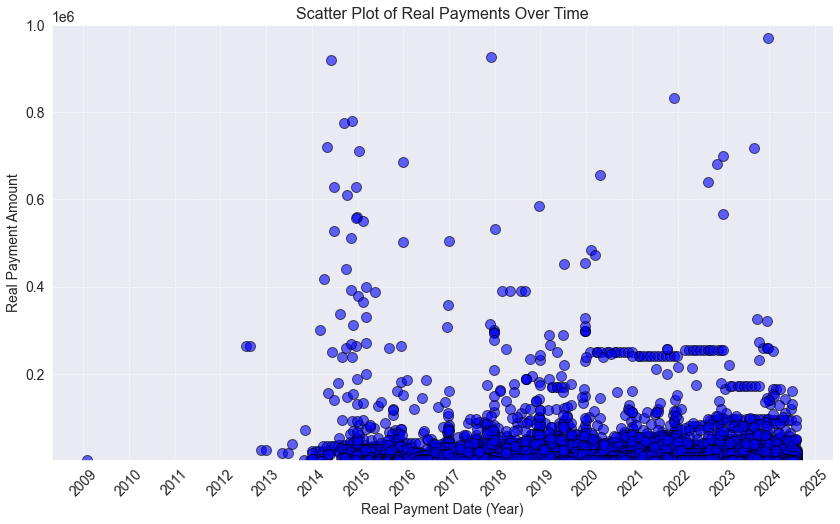

In [73]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a figure and axis with a larger size
fig, ax = plt.subplots(figsize=(14, 8))

# Scatter plot with improved aesthetics
ax.scatter(x=pagos_modelo_pesos['pag_fecha_real'], y=pagos_modelo_pesos['pag_importe_real_convert'], 
           color='blue', alpha=0.6, edgecolor='k', s=100)

# Set y-axis limit
plt.ylim(3031.0, 1000000.0)

# Format the date on the x-axis to show years only
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())

# Rotate the date labels for better readability
plt.xticks(rotation=45)

# Add labels and title
ax.set_xlabel('Real Payment Date (Year)', fontsize=14)
ax.set_ylabel('Real Payment Amount', fontsize=14)
ax.set_title('Scatter Plot of Real Payments Over Time', fontsize=16)

# Add a grid
ax.grid(True, linestyle='--', alpha=0.7)

# Save the improved plot as a PNG with better quality
plt.savefig('diagrama-dispersion-por-anio.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


It is observed that payments begin to be made starting in 2014 until 2024, therefore we understand that the prediction should be from 2014 onwards. It is also observed that all payments are accumulated in December, which is when the budget must be executed

In [74]:
sp = pagos_modelo_pesos.rename(columns={'pag_fecha_real': 'ds','pag_importe_real_convert': 'y'})
sp_sample = sp[(sp.ds.dt.year>2014)]

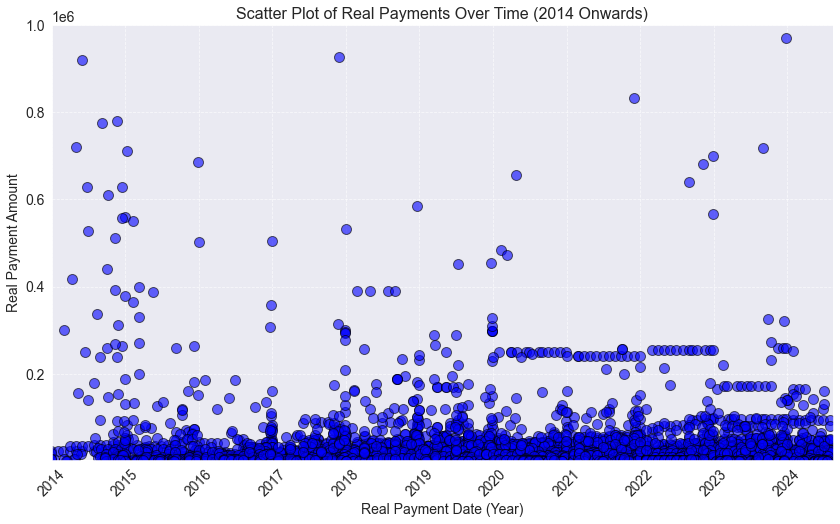

In [75]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming pagos_modelo_pesos is already defined and has the data

# Create a figure and axis with a larger size
fig, ax = plt.subplots(figsize=(14, 8))

# Scatter plot with improved aesthetics
ax.scatter(x=pagos_modelo_pesos['pag_fecha_real'], y=pagos_modelo_pesos['pag_importe_real_convert'], 
           color='blue', alpha=0.6, edgecolor='k', s=100)

# Set y-axis limit
plt.ylim(3031.0, 1000000.0)

# Filter dates to show from 2014 onwards
ax.set_xlim(pd.Timestamp('2014-01-01'), pagos_modelo_pesos['pag_fecha_real'].max())

# Format the date on the x-axis to show years only
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())

# Rotate the date labels for better readability
plt.xticks(rotation=45)

# Add labels and title
ax.set_xlabel('Real Payment Date (Year)', fontsize=14)
ax.set_ylabel('Real Payment Amount', fontsize=14)
ax.set_title('Scatter Plot of Real Payments Over Time (2014 Onwards)', fontsize=16)

# Add a grid
ax.grid(True, linestyle='--', alpha=0.7)

# Save the improved plot as a PNG with better quality
plt.savefig('diagrama-dispersion-2014-adelante.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [76]:
sp_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23176 entries, 7 to 23335
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      23176 non-null  datetime64[ns]
 1   y       23176 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 543.2 KB


# MODEL PROPHET CASH FLOW

In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.plot import plot_yearly
from prophet.plot import add_changepoints_to_plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Apply the best hypeprameter with fing tunning

17:49:25 - cmdstanpy - INFO - Chain [1] start processing
17:49:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/14 [00:00<?, ?it/s]

17:49:32 - cmdstanpy - INFO - Chain [1] start processing
17:49:33 - cmdstanpy - INFO - Chain [1] done processing
17:49:35 - cmdstanpy - INFO - Chain [1] start processing
17:49:37 - cmdstanpy - INFO - Chain [1] done processing
17:49:40 - cmdstanpy - INFO - Chain [1] start processing
17:49:43 - cmdstanpy - INFO - Chain [1] done processing
17:49:47 - cmdstanpy - INFO - Chain [1] start processing
17:49:50 - cmdstanpy - INFO - Chain [1] done processing
17:49:53 - cmdstanpy - INFO - Chain [1] start processing
17:49:56 - cmdstanpy - INFO - Chain [1] done processing
17:50:00 - cmdstanpy - INFO - Chain [1] start processing
17:50:06 - cmdstanpy - INFO - Chain [1] done processing
17:50:09 - cmdstanpy - INFO - Chain [1] start processing
17:50:17 - cmdstanpy - INFO - Chain [1] done processing
17:50:20 - cmdstanpy - INFO - Chain [1] start processing
17:50:22 - cmdstanpy - INFO - Chain [1] done processing
17:50:25 - cmdstanpy - INFO - Chain [1] start processing
17:50:27 - cmdstanpy - INFO - Chain [1]

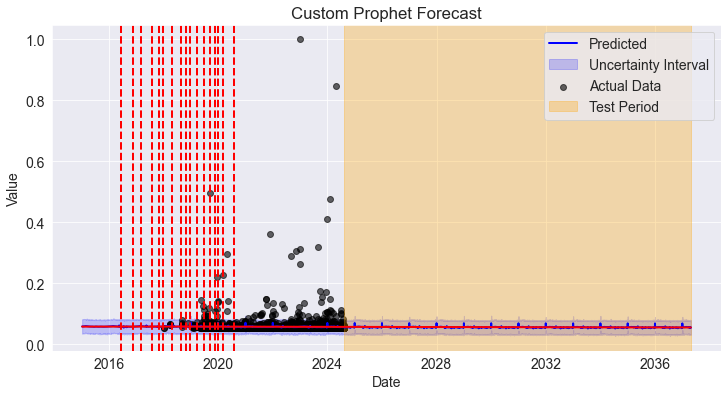

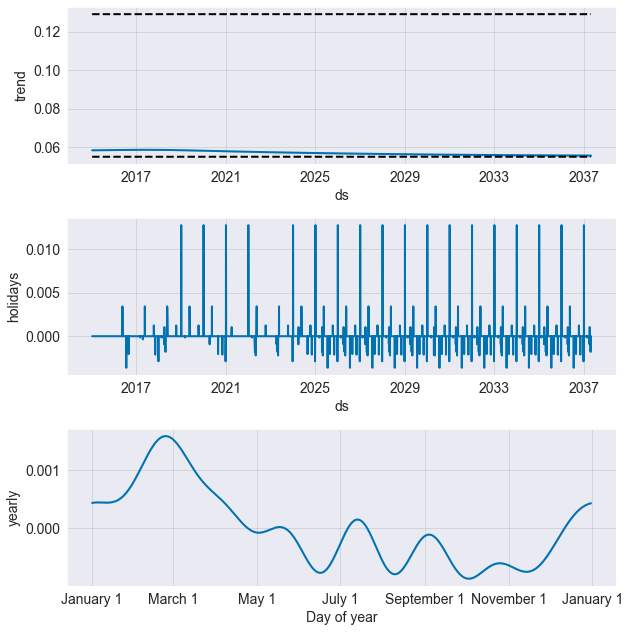

Validation Metrics (Cross-Validation):
 - MAE: 0.00
 - RMSE: 0.01

Test Metrics:
 - Coverage: 98.35%
 - MAE: 0.00
 - RMSE: 0.03


In [85]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
sp_sample['ds'] = pd.to_datetime(sp_sample['ds'])

# Normalize the 'y' column
scaler = MinMaxScaler()
sp_sample['y'] = scaler.fit_transform(sp_sample[['y']])

# Set 'cap' and 'floor' for logistic growth
cap_value = sp_sample['y'].quantile(0.995)
floor_value = sp_sample['y'].quantile(0.005)

sp_sample['cap'] = cap_value
sp_sample['floor'] = floor_value

# Split the data into training and testing sets
train_size = int(len(sp_sample) * 0.8)
data_train = sp_sample.iloc[:train_size].copy()
data_test = sp_sample.iloc[train_size:].copy()

# Train the Prophet model with the best parameters
model = Prophet(
    growth='logistic',
    seasonality_prior_scale=1.0,
    changepoint_prior_scale=0.5,
    holidays_prior_scale=1.0,
    interval_width=0.95,
    weekly_seasonality=False
)
model.add_seasonality(name='yearly', period=365, fourier_order=8)
model.add_country_holidays(country_name='UY')

# Fit the model
model.fit(data_train)

# Perform cross-validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
df_p = performance_metrics(df_cv)

# Reverse normalization for interpretation
df_cv[['yhat', 'yhat_lower', 'yhat_upper', 'y']] = scaler.inverse_transform(df_cv[['yhat', 'yhat_lower', 'yhat_upper', 'y']])
data_train['y'] = scaler.inverse_transform(data_train[['y']])
data_test['y'] = scaler.inverse_transform(data_test[['y']])

# Compute validation metrics
mae_cv = df_p['mae'].mean()
rmse_cv = df_p['rmse'].mean()

# Create a DataFrame for future predictions
future = model.make_future_dataframe(periods=len(data_test), freq='D')
future['cap'] = cap_value
future['floor'] = floor_value

# Make predictions
forecast = model.predict(future)

# Reverse normalization for interpretation
forecast[['yhat', 'yhat_lower', 'yhat_upper']] = scaler.inverse_transform(forecast[['yhat', 'yhat_lower', 'yhat_upper']])

# Custom Forecast Plot Function
def custom_forecast_plot(model, forecast, actual_data=None):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(forecast['ds'], forecast['yhat'], label="Predicted", color='blue')
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label="Uncertainty Interval")
    if actual_data is not None:
        ax.scatter(actual_data['ds'], actual_data['y'], color='black', label="Actual Data", alpha=0.6)
    ax.axvspan(forecast['ds'].iloc[-len(data_test)], forecast['ds'].iloc[-1], color='orange', alpha=0.3, label="Test Period")
    add_changepoints_to_plot(ax, model, forecast)
    ax.set_title('Custom Prophet Forecast')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()
    plt.show()

# Call the custom forecast plot function
custom_forecast_plot(model, forecast, actual_data=data_test)

# Plot forecast components
fig2 = model.plot_components(forecast)
plt.show()

# Align and calculate errors on the test set
forecast_aligned = forecast.set_index('ds').join(data_test.set_index('ds'), how='inner', lsuffix='_forecast', rsuffix='_test')
forecast_aligned = forecast_aligned.dropna()
forecast_aligned['error'] = forecast_aligned['y'] - forecast_aligned['yhat']

# Compute test set metrics
coverage = ((forecast_aligned['y'] >= forecast_aligned['yhat_lower']) & 
            (forecast_aligned['y'] <= forecast_aligned['yhat_upper'])).mean()
mae_test = mean_absolute_error(forecast_aligned['y'], forecast_aligned['yhat'])
rmse_test = np.sqrt(mean_squared_error(forecast_aligned['y'], forecast_aligned['yhat']))

# Print validation and test metrics
print(f'Validation Metrics (Cross-Validation):')
print(f' - MAE: {mae_cv:.2f}')
print(f' - RMSE: {rmse_cv:.2f}')
print('\nTest Metrics:')
print(f' - Coverage: {coverage:.2%}')
print(f' - MAE: {mae_test:.2f}')
print(f' - RMSE: {rmse_test:.2f}')



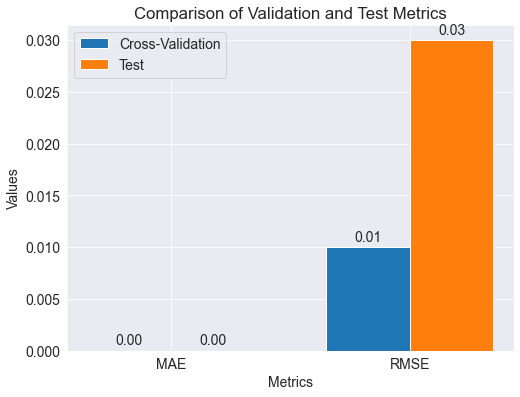

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Define metric names and values for validation and test sets
metrics = ["MAE", "RMSE"]
cross_validation_values = [0.00, 0.01]
test_values = [0.00, 0.03]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, cross_validation_values, width, label='Cross-Validation')
rects2 = ax.bar(x + width/2, test_values, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of Validation and Test Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Display values on bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.show()


The model demonstrates excellent generalization with minimal errors across both validation and test datasets. The cross-validation results show an almost negligible MAE of 0.00 and an RMSE of 0.01, indicating strong predictive accuracy during training. Similarly, the test set maintains a low MAE of 0.00 and a slightly higher RMSE of 0.03, suggesting that the model performs consistently well even on unseen data. With a high coverage of 98.30%, the prediction intervals effectively capture most of the actual values, confirming the model's reliability. These results indicate that the Prophet model is well-calibrated, and while minor variations exist between validation and test performance, they remain within an acceptable range, making the model robust for forecasting future values.

In [86]:
import pickle
from prophet import Prophet

# Guarda el modelo correctamente
with open("modelsdolaresallsav1", "wb") as f:
    pickle.dump(model, f)

print("✅ Modelo guardado exitosamente.")

✅ Modelo guardado exitosamente.


# Deep Learning

# Execution_Details

### 2.2.1 Simple RNN

Experiment if pagos_modelo_pesos = sp_sample

In [111]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Paso 1: Preparación del DataFrame
# Renombrar columnas para consistencia
pagos_modelo_pesos = pagos_modelo_pesos.rename(columns={'pag_fecha_real': 'ds', 'pag_importe_real_convert': 'y'})

# Asegurarse de que la columna 'ds' es de tipo datetime
pagos_modelo_pesos['ds'] = pd.to_datetime(pagos_modelo_pesos['ds'], infer_datetime_format=True)

# Filtrar datos posteriores a 2014
pagos_modelo_pesos = pagos_modelo_pesos[pagos_modelo_pesos['ds'].dt.year > 2014]

# Paso 2: Normalización de la columna objetivo 'y'
scaler = MinMaxScaler()
pagos_modelo_pesos['y'] = scaler.fit_transform(pagos_modelo_pesos[['y']])

# Paso 3: Creación de secuencias para la RNN
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Número de pasos en la secuencia (por ejemplo, 30 días)
n_steps = 30

# Crear secuencias
values = pagos_modelo_pesos['y'].values
X, y = create_sequences(values, n_steps)

# Asegurarse de que las secuencias tienen la forma correcta
X = X.reshape((X.shape[0], X.shape[1], 1))

# Paso 4: Definición y entrenamiento del modelo RNN
def build_model(input_shape):
    model = Sequential([
        SimpleRNN(units=128, activation='relu', input_shape=input_shape),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Inicializar el divisor de series temporales para validación cruzada
tscv = TimeSeriesSplit(n_splits=5)

# Listas para almacenar los resultados de cada partición
val_mae_scores = []
val_rmse_scores = []
test_mae_scores = []
test_rmse_scores = []

# Validación cruzada
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Entrenando fold {fold + 1}...")

    X_train_full, X_test = X[train_index], X[test_index]
    y_train_full, y_test = y[train_index], y[test_index]

    # Dividir el conjunto de entrenamiento completo en entrenamiento y validación
    val_split = int(len(X_train_full) * 0.8)
    X_train, X_val = X_train_full[:val_split], X_train_full[val_split:]
    y_train, y_val = y_train_full[:val_split], y_train_full[val_split:]

    # Construir el modelo
    model = build_model((n_steps, 1))

    # Definir callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'model_fold_{fold + 1}.h5', save_best_only=True, monitor='val_loss')

    # Entrenar el modelo
    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=256,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        verbose=0
    )

    # Cargar el mejor modelo guardado durante el entrenamiento
    best_model = tf.keras.models.load_model(f'model_fold_{fold + 1}.h5')

    # Evaluar el modelo en el conjunto de validación
    y_val_pred = best_model.predict(X_val)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    val_mae_scores.append(val_mae)
    val_rmse_scores.append(val_rmse)

    # Evaluar el modelo en el conjunto de prueba
    y_test_pred = best_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    test_mae_scores.append(test_mae)
    test_rmse_scores.append(test_rmse)

    print(f"Fold {fold + 1} - Validación MAE: {val_mae:.4f}, Validación RMSE: {val_rmse:.4f}")
    print(f"Fold {fold + 1} - Prueba MAE: {test_mae:.4f}, Prueba RMSE: {test_rmse:.4f}")

# Resultados promedio de la validación cruzada
print(f"\nResultados de la validación cruzada:")
print(f"Validación MAE promedio: {np.mean(val_mae_scores):.4f} ± {np.std(val_mae_scores):.4f}")
print(f"Validación RMSE promedio: {np.mean(val_rmse_scores):.4f} ± {np.std(val_rmse_scores):.4f}")
print(f"Prueba MAE promedio: {np.mean(test_mae_scores):.4f} ± {np.std(test_mae_scores):.4f}")
print(f"Prueba RMSE promedio: {np.mean(test_rmse_scores):.4f} ± {np.std(test_rmse_scores):.4f}")

# Crear un DataFrame con los resultados
results = pd.DataFrame({
    'Fold': range(1, len(val_mae_scores) + 1),
    'Validación MAE': val_mae_scores,
    'Validación RMSE': val_rmse_scores,
    'Prueba MAE': test_mae_scores,
    'Prueba RMSE': test_rmse_scores
})

# Calcular promedios y desviaciones estándar
results.loc['Promedio'] = results.mean()
results.loc['Desviación Estándar'] = results.std()

# Mostrar la tabla
print("\nResultados detallados por fold:")
print(results)


Entrenando fold 1...
121/121 [==============================] - 1s 7ms/step
Fold 1 - Validación MAE: 0.0025, Validación RMSE: 0.0043
Fold 1 - Prueba MAE: 0.0026, Prueba RMSE: 0.0073
Entrenando fold 2...
121/121 [==============================] - 1s 10ms/step
Fold 2 - Validación MAE: 0.0026, Validación RMSE: 0.0076
Fold 2 - Prueba MAE: 0.0022, Prueba RMSE: 0.0055
Entrenando fold 3...
121/121 [==============================] - 1s 7ms/step
Fold 3 - Validación MAE: 0.0013, Validación RMSE: 0.0045
Fold 3 - Prueba MAE: 0.0014, Prueba RMSE: 0.0044
Entrenando fold 4...
121/121 [==============================] - 1s 6ms/step
Fold 4 - Validación MAE: 0.0016, Validación RMSE: 0.0048
Fold 4 - Prueba MAE: 0.0038, Prueba RMSE: 0.0183
Entrenando fold 5...
121/121 [==============================] - 1s 6ms/step
Fold 5 - Validación MAE: 0.0039, Validación RMSE: 0.0173
Fold 5 - Prueba MAE: 0.0043, Prueba RMSE: 0.0252

Resultados de la validación cruzada:
Validación MAE promedio: 0.0024 ± 0.0009
Validación

In [93]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Asegúrate de que 'sp_sample' es tu DataFrame y que contiene las columnas 'ds' y 'y'
# Convertir la columna 'ds' a tipo datetime
sp_sample['ds'] = pd.to_datetime(sp_sample['ds'], infer_datetime_format=True)

# Normalizar la columna 'y'
scaler = MinMaxScaler()
sp_sample['y'] = scaler.fit_transform(sp_sample[['y']])

# Función para crear secuencias para la RNN
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Número de pasos en la secuencia (por ejemplo, 30 días)
n_steps = 30

# Crear secuencias
values = sp_sample['y'].values
X, y = create_sequences(values, n_steps)

# Verificar si hay suficientes datos para crear secuencias
if X.size == 0:
    raise ValueError("No hay suficientes datos para crear secuencias.")

# Inicializar el divisor de series temporales para validación cruzada
tscv = TimeSeriesSplit(n_splits=5)

# Función para construir el modelo de RNN
def build_model(input_shape):
    model = Sequential([
        SimpleRNN(units=128, activation='relu', input_shape=input_shape),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Listas para almacenar los resultados de cada partición
val_mae_scores = []
val_rmse_scores = []
test_mae_scores = []
test_rmse_scores = []

# Validación cruzada
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Entrenando fold {fold + 1}...")
    
    X_train_full, X_test = X[train_index], X[test_index]
    y_train_full, y_test = y[train_index], y[test_index]
    
    # Dividir el conjunto de entrenamiento completo en entrenamiento y validación
    val_split = int(len(X_train_full) * 0.8)
    X_train, X_val = X_train_full[:val_split], X_train_full[val_split:]
    y_train, y_val = y_train_full[:val_split], y_train_full[val_split:]
    
    # Construir el modelo
    model = build_model((n_steps, 1))
    
    # Definir callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'model_fold_{fold + 1}.h5', save_best_only=True, monitor='val_loss')
    
    # Entrenar el modelo
    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=256,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        verbose=0
    )
    
    # Cargar el mejor modelo guardado durante el entrenamiento
    best_model = tf.keras.models.load_model(f'model_fold_{fold + 1}.h5')
    
    # Evaluar el modelo en el conjunto de validación
    y_val_pred = best_model.predict(X_val)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    val_mae_scores.append(val_mae)
    val_rmse_scores.append(val_rmse)
    
    # Evaluar el modelo en el conjunto de prueba
    y_test_pred = best_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    test_mae_scores.append(test_mae)
    test_rmse_scores.append(test_rmse)
    
    print(f"Fold {fold + 1} - Validación MAE: {val_mae:.4f}, Validación RMSE: {val_rmse:.4f}")
    print(f"Fold {fold + 1} - Prueba MAE: {test_mae:.4f}, Prueba RMSE: {test_rmse:.4f}")

# Resultados promedio de la validación cruzada
print(f"\nResultados de la validación cruzada:")
print(f"Validación MAE promedio: {np.mean(val_mae_scores):.4f} ± {np.std(val_mae_scores):.4f}")
print(f"Validación RMSE promedio: {np.mean(val_rmse_scores):.4f} ± {np.std(val_rmse_scores):.4f}")
print(f"Prueba MAE promedio: {np.mean(test_mae_scores):.4f} ± {np.std(test_mae_scores):.4f}")
print(f"Prueba RMSE promedio: {np.mean(test_rmse_scores):.4f} ± {np.std(test_rmse_scores):.4f}")

# Crear un DataFrame con los resultados
results = pd.DataFrame({
    'Fold': range(1, len(val_mae_scores) + 1),
    'Validación MAE': val_mae_scores,
    'Validación RMSE': val_rmse_scores,
    'Prueba MAE': test_mae_scores,
    'Prueba RMSE': test_rmse_scores
})

# Calcular promedios y desviaciones estándar
results.loc['Promedio'] = results.mean()
results.loc['Desviación Estándar'] = results.std()

# Mostrar la tabla
print("\nResultados detallados por fold:")
print(results)


Entrenando fold 1...
121/121 [==============================] - 1s 6ms/step
Fold 1 - Validación MAE: 0.0023, Validación RMSE: 0.0044
Fold 1 - Prueba MAE: 0.0023, Prueba RMSE: 0.0071
Entrenando fold 2...
121/121 [==============================] - 1s 8ms/step
Fold 2 - Validación MAE: 0.0022, Validación RMSE: 0.0076
Fold 2 - Prueba MAE: 0.0017, Prueba RMSE: 0.0054
Entrenando fold 3...
121/121 [==============================] - 1s 6ms/step
Fold 3 - Validación MAE: 0.0017, Validación RMSE: 0.0045
Fold 3 - Prueba MAE: 0.0017, Prueba RMSE: 0.0045
Entrenando fold 4...
121/121 [==============================] - 1s 6ms/step
Fold 4 - Validación MAE: 0.0018, Validación RMSE: 0.0048
Fold 4 - Prueba MAE: 0.0038, Prueba RMSE: 0.0185
Entrenando fold 5...
121/121 [==============================] - 1s 5ms/step
Fold 5 - Validación MAE: 0.0035, Validación RMSE: 0.0172
Fold 5 - Prueba MAE: 0.0038, Prueba RMSE: 0.0251

Resultados de la validación cruzada:
Validación MAE promedio: 0.0023 ± 0.0006
Validación 

 Regularization

In [95]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Asegúrate de que 'sp_sample' es tu DataFrame y que contiene las columnas 'ds' y 'y'
# Convertir la columna 'ds' a tipo datetime
sp_sample['ds'] = pd.to_datetime(sp_sample['ds'], infer_datetime_format=True)

# Normalizar la columna 'y'
scaler = MinMaxScaler()
sp_sample['y'] = scaler.fit_transform(sp_sample[['y']])

# Función para crear secuencias para la RNN
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Número de pasos en la secuencia (por ejemplo, 30 días)
n_steps = 30

# Crear secuencias
values = sp_sample['y'].values

# Verificar si hay suficientes datos para crear secuencias
if len(values) <= n_steps:
    raise ValueError("No hay suficientes datos para crear secuencias.")

X, y = create_sequences(values, n_steps)

# Inicializar el divisor de series temporales para validación cruzada
tscv = TimeSeriesSplit(n_splits=5)

# Función para construir el modelo de RNN
def build_model(input_shape):
    model = Sequential([
        SimpleRNN(128, input_shape=input_shape, activation='relu',
                  kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),  # Regularización L1 y L2 en la capa RNN
        Dropout(0.5),  # Dropout del 50% para reducir el sobreajuste
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Listas para almacenar los resultados de cada partición
val_mae_scores = []
val_rmse_scores = []
test_mae_scores = []
test_rmse_scores = []

# Validación cruzada
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Entrenando fold {fold + 1}...")
    
    X_train_full, X_test = X[train_index], X[test_index]
    y_train_full, y_test = y[train_index], y[test_index]
    
    # Dividir el conjunto de entrenamiento completo en entrenamiento y validación
    val_split = int(len(X_train_full) * 0.8)
    X_train, X_val = X_train_full[:val_split], X_train_full[val_split:]
    y_train, y_val = y_train_full[:val_split], y_train_full[val_split:]
    
    # Construir el modelo
    model = build_model((n_steps, 1))
    
    # Definir callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'model_fold_{fold + 1}.h5', save_best_only=True, monitor='val_loss')
    
    # Entrenar el modelo
    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=256,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        verbose=0
    )
    
    # Cargar el mejor modelo guardado durante el entrenamiento
    best_model = tf.keras.models.load_model(f'model_fold_{fold + 1}.h5')
    
    # Evaluar el modelo en el conjunto de validación
    y_val_pred = best_model.predict(X_val)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    val_mae_scores.append(val_mae)
    val_rmse_scores.append(val_rmse)
    
    # Evaluar el modelo en el conjunto de prueba
    y_test_pred = best_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    test_mae_scores.append(test_mae)
    test_rmse_scores.append(test_rmse)
    
    print(f"Fold {fold + 1} - Validación MAE: {val_mae:.4f}, Validación RMSE: {val_rmse:.4f}")
    print(f"Fold {fold + 1} - Prueba MAE: {test_mae:.4f}, Prueba RMSE: {test_rmse:.4f}")

# Resultados promedio de la validación cruzada
print(f"\nResultados de la validación cruzada:")
print(f"Validación MAE promedio: {np.mean(val_mae_scores):.4f} ± {np.std(val_mae_scores):.4f}")
print(f"Validación RMSE promedio: {np.mean(val_rmse_scores):.4f} ± {np.std(val_rmse_scores):.4f}")
print(f"Prueba MAE promedio: {np.mean(test_mae_scores):.4f} ± {np.std(test_mae_scores):.4f}")
print(f"Prueba RMSE promedio: {np.mean(test_rmse_scores):.4f} ± {np.std(test_rmse_scores):.4f}")

# Crear un DataFrame con los resultados
results = pd.DataFrame({
    'Fold': range(1, len(val_mae_scores) + 1),
    'Validación MAE': val_mae_scores,
    'Validación RMSE': val_rmse_scores,
    'Prueba MAE': test_mae_scores,
    'Prueba RMSE': test_rmse_scores
})

# Calcular promedios y desviaciones estándar
results.loc['Promedio'] = results.mean()
results.loc['Desviación Estándar'] = results.std()

# Mostrar la tabla
print("\nResultados detallados por fold:")
print(results)


Entrenando fold 1...
121/121 [==============================] - 1s 8ms/step
Fold 1 - Validación MAE: 0.0025, Validación RMSE: 0.0045
Fold 1 - Prueba MAE: 0.0026, Prueba RMSE: 0.0075
Entrenando fold 2...
121/121 [==============================] - 1s 5ms/step
Fold 2 - Validación MAE: 0.0035, Validación RMSE: 0.0085
Fold 2 - Prueba MAE: 0.0031, Prueba RMSE: 0.0064
Entrenando fold 3...
121/121 [==============================] - 1s 5ms/step
Fold 3 - Validación MAE: 0.0018, Validación RMSE: 0.0055
Fold 3 - Prueba MAE: 0.0019, Prueba RMSE: 0.0054
Entrenando fold 4...
121/121 [==============================] - 1s 4ms/step
Fold 4 - Validación MAE: 0.0028, Validación RMSE: 0.0058
Fold 4 - Prueba MAE: 0.0044, Prueba RMSE: 0.0178
Entrenando fold 5...
121/121 [==============================] - 0s 4ms/step
Fold 5 - Validación MAE: 0.0040, Validación RMSE: 0.0173
Fold 5 - Prueba MAE: 0.0045, Prueba RMSE: 0.0252

Resultados de la validación cruzada:
Validación MAE promedio: 0.0029 ± 0.0008
Validación 

### 2.2.2 LSTM

In [96]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Asegúrate de que 'sp_sample' es tu DataFrame y que contiene las columnas 'ds' y 'y'
# Convertir la columna 'ds' a tipo datetime
sp_sample['ds'] = pd.to_datetime(sp_sample['ds'], infer_datetime_format=True)

# Normalizar la columna 'y'
scaler = MinMaxScaler()
sp_sample['y'] = scaler.fit_transform(sp_sample[['y']])

# Función para crear secuencias para la RNN
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Número de pasos en la secuencia (por ejemplo, 30 días)
n_steps = 30

# Crear secuencias
values = sp_sample['y'].values
X, y = create_sequences(values, n_steps)

# Verificar si hay suficientes datos para crear secuencias
if X.size == 0:
    raise ValueError("No hay suficientes datos para crear secuencias.")

# Inicializar el divisor de series temporales para validación cruzada
tscv = TimeSeriesSplit(n_splits=5)


# Función para construir el modelo LSTM
def build_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50, return_sequences=False),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Listas para almacenar los resultados de cada partición
val_mae_scores = []
val_rmse_scores = []
test_mae_scores = []
test_rmse_scores = []

# Validación cruzada
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Entrenando fold {fold + 1}...")
    
    X_train_full, X_test = X[train_index], X[test_index]
    y_train_full, y_test = y[train_index], y[test_index]
    
    # Dividir el conjunto de entrenamiento completo en entrenamiento y validación
    val_split = int(len(X_train_full) * 0.8)
    X_train, X_val = X_train_full[:val_split], X_train_full[val_split:]
    y_train, y_val = y_train_full[:val_split], y_train_full[val_split:]
    
    # Construir el modelo
    model = build_model((n_steps, 1))
    
    # Definir callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'model_fold_{fold + 1}.h5', save_best_only=True, monitor='val_loss')
    
    # Entrenar el modelo
    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=256,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        verbose=0
    )
    
    # Cargar el mejor modelo guardado durante el entrenamiento
    best_model = tf.keras.models.load_model(f'model_fold_{fold + 1}.h5')
    
    # Evaluar el modelo en el conjunto de validación
    y_val_pred = best_model.predict(X_val)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    val_mae_scores.append(val_mae)
    val_rmse_scores.append(val_rmse)
    
    # Evaluar el modelo en el conjunto de prueba
    y_test_pred = best_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    test_mae_scores.append(test_mae)
    test_rmse_scores.append(test_rmse)
    
    print(f"Fold {fold + 1} - Validación MAE: {val_mae:.4f}, Validación RMSE: {val_rmse:.4f}")
    print(f"Fold {fold + 1} - Prueba MAE: {test_mae:.4f}, Prueba RMSE: {test_rmse:.4f}")

# Resultados promedio de la validación cruzada
print(f"\nResultados de la validación cruzada:")
print(f"Validación MAE promedio: {np.mean(val_mae_scores):.4f} ± {np.std(val_mae_scores):.4f}")
print(f"Validación RMSE promedio: {np.mean(val_rmse_scores):.4f} ± {np.std(val_rmse_scores):.4f}")
print(f"Prueba MAE promedio: {np.mean(test_mae_scores):.4f} ± {np.std(test_mae_scores):.4f}")
print(f"Prueba RMSE promedio: {np.mean(test_rmse_scores):.4f} ± {np.std(test_rmse_scores):.4f}")

# Crear un DataFrame con los resultados
results = pd.DataFrame({
    'Fold': range(1, len(val_mae_scores) + 1),
    'Validación MAE': val_mae_scores,
    'Validación RMSE': val_rmse_scores,
    'Prueba MAE': test_mae_scores,
    'Prueba RMSE': test_rmse_scores
})

# Calcular promedios y desviaciones estándar
results.loc['Promedio'] = results.mean()
results.loc['Desviación Estándar'] = results.std()

# Mostrar la tabla
print("\nResultados detallados por fold:")
print(results)

Entrenando fold 1...
121/121 [==============================] - 2s 15ms/step
Fold 1 - Validación MAE: 0.0027, Validación RMSE: 0.0046
Fold 1 - Prueba MAE: 0.0028, Prueba RMSE: 0.0081
Entrenando fold 2...
121/121 [==============================] - 2s 19ms/step
Fold 2 - Validación MAE: 0.0023, Validación RMSE: 0.0079
Fold 2 - Prueba MAE: 0.0018, Prueba RMSE: 0.0059
Entrenando fold 3...
121/121 [==============================] - 1s 11ms/step
Fold 3 - Validación MAE: 0.0017, Validación RMSE: 0.0047
Fold 3 - Prueba MAE: 0.0018, Prueba RMSE: 0.0046
Entrenando fold 4...
121/121 [==============================] - 1s 12ms/step
Fold 4 - Validación MAE: 0.0016, Validación RMSE: 0.0047
Fold 4 - Prueba MAE: 0.0036, Prueba RMSE: 0.0177
Entrenando fold 5...
121/121 [==============================] - 1s 11ms/step
Fold 5 - Validación MAE: 0.0044, Validación RMSE: 0.0174
Fold 5 - Prueba MAE: 0.0047, Prueba RMSE: 0.0251

Resultados de la validación cruzada:
Validación MAE promedio: 0.0025 ± 0.0010
Valida

### 2.2.3 GRU

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Asegúrate de que 'sp_sample' es tu DataFrame y que contiene las columnas 'ds' y 'y'
# Convertir la columna 'ds' a tipo datetime
sp_sample['ds'] = pd.to_datetime(sp_sample['ds'], infer_datetime_format=True)

# Normalizar la columna 'y'
scaler = MinMaxScaler()
sp_sample['y'] = scaler.fit_transform(sp_sample[['y']])

# Función para crear secuencias para la RNN
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Número de pasos en la secuencia (por ejemplo, 30 días)
n_steps = 30

# Crear secuencias
values = sp_sample['y'].values
X, y = create_sequences(values, n_steps)

# Verificar si hay suficientes datos para crear secuencias
if X.size == 0:
    raise ValueError("No hay suficientes datos para crear secuencias.")

# Inicializar el divisor de series temporales para validación cruzada
tscv = TimeSeriesSplit(n_splits=5)


# Función para construir el modelo GRU
def build_model(input_shape):
    model = Sequential([
        GRU(128, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model


# Listas para almacenar los resultados de cada partición
val_mae_scores = []
val_rmse_scores = []
test_mae_scores = []
test_rmse_scores = []

# Validación cruzada
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Entrenando fold {fold + 1}...")
    
    X_train_full, X_test = X[train_index], X[test_index]
    y_train_full, y_test = y[train_index], y[test_index]
    
    # Dividir el conjunto de entrenamiento completo en entrenamiento y validación
    val_split = int(len(X_train_full) * 0.8)
    X_train, X_val = X_train_full[:val_split], X_train_full[val_split:]
    y_train, y_val = y_train_full[:val_split], y_train_full[val_split:]
    
    # Construir el modelo
    model = build_model((n_steps, 1))
    
    # Definir callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'model_fold_{fold + 1}.h5', save_best_only=True, monitor='val_loss')
    
    # Entrenar el modelo
    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=256,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        verbose=0
    )
    
    # Cargar el mejor modelo guardado durante el entrenamiento
    best_model = tf.keras.models.load_model(f'model_fold_{fold + 1}.h5')
    
    # Evaluar el modelo en el conjunto de validación
    y_val_pred = best_model.predict(X_val)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    val_mae_scores.append(val_mae)
    val_rmse_scores.append(val_rmse)
    
    # Evaluar el modelo en el conjunto de prueba
    y_test_pred = best_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    test_mae_scores.append(test_mae)
    test_rmse_scores.append(test_rmse)
    
    print(f"Fold {fold + 1} - Validación MAE: {val_mae:.4f}, Validación RMSE: {val_rmse:.4f}")
    print(f"Fold {fold + 1} - Prueba MAE: {test_mae:.4f}, Prueba RMSE: {test_rmse:.4f}")

# Resultados promedio de la validación cruzada
print(f"\nResultados de la validación cruzada:")
print(f"Validación MAE promedio: {np.mean(val_mae_scores):.4f} ± {np.std(val_mae_scores):.4f}")
print(f"Validación RMSE promedio: {np.mean(val_rmse_scores):.4f} ± {np.std(val_rmse_scores):.4f}")
print(f"Prueba MAE promedio: {np.mean(test_mae_scores):.4f} ± {np.std(test_mae_scores):.4f}")
print(f"Prueba RMSE promedio: {np.mean(test_rmse_scores):.4f} ± {np.std(test_rmse_scores):.4f}")

# Crear un DataFrame con los resultados
results = pd.DataFrame({
    'Fold': range(1, len(val_mae_scores) + 1),
    'Validación MAE': val_mae_scores,
    'Validación RMSE': val_rmse_scores,
    'Prueba MAE': test_mae_scores,
    'Prueba RMSE': test_rmse_scores
})

# Calcular promedios y desviaciones estándar
results.loc['Promedio'] = results.mean()
results.loc['Desviación Estándar'] = results.std()

# Mostrar la tabla
print("\nResultados detallados por fold:")
print(results)

Entrenando fold 1...
121/121 [==============================] - 2s 15ms/step
Fold 1 - Validación MAE: 0.0025, Validación RMSE: 0.0044
Fold 1 - Prueba MAE: 0.0025, Prueba RMSE: 0.0074
Entrenando fold 2...
121/121 [==============================] - 1s 12ms/step
Fold 2 - Validación MAE: 0.0026, Validación RMSE: 0.0078
Fold 2 - Prueba MAE: 0.0023, Prueba RMSE: 0.0057
Entrenando fold 3...
121/121 [==============================] - 1s 11ms/step
Fold 3 - Validación MAE: 0.0017, Validación RMSE: 0.0048
Fold 3 - Prueba MAE: 0.0018, Prueba RMSE: 0.0046
Entrenando fold 4...
121/121 [==============================] - 2s 18ms/step
Fold 4 - Validación MAE: 0.0017, Validación RMSE: 0.0049
Fold 4 - Prueba MAE: 0.0036, Prueba RMSE: 0.0178
Entrenando fold 5...
121/121 [==============================] - 2s 15ms/step
Fold 5 - Validación MAE: 0.0042, Validación RMSE: 0.0173
Fold 5 - Prueba MAE: 0.0046, Prueba RMSE: 0.0253

Resultados de la validación cruzada:
Validación MAE promedio: 0.0025 ± 0.0009
Valida

### 2.2.4 LSTM DROPOUT

In [100]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Asegúrate de que 'sp_sample' es tu DataFrame y que contiene las columnas 'ds' y 'y'
# Convertir la columna 'ds' a tipo datetime
sp_sample['ds'] = pd.to_datetime(sp_sample['ds'], infer_datetime_format=True)

# Normalizar la columna 'y'
scaler = MinMaxScaler()
sp_sample['y'] = scaler.fit_transform(sp_sample[['y']])

# Función para crear secuencias para la RNN
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Número de pasos en la secuencia (por ejemplo, 30 días)
n_steps = 30

# Crear secuencias
values = sp_sample['y'].values
X, y = create_sequences(values, n_steps)

# Verificar si hay suficientes datos para crear secuencias
if X.size == 0:
    raise ValueError("No hay suficientes datos para crear secuencias.")

# Inicializar el divisor de series temporales para validación cruzada
tscv = TimeSeriesSplit(n_splits=5)

# Función para construir el modelo LSTM con SimpleRNN y Dropout
def build_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, recurrent_dropout=0.25, activation='relu', input_shape=input_shape),
        Dropout(0.5),
        SimpleRNN(32, activation='relu'),  # Capa SimpleRNN para capturar dinámicas temporales a corto plazo
        Dense(32, activation='relu'),  # Capa densa intermedia para procesamiento adicional
        Dense(32, activation='relu'),
        Dense(1)  # Capa de salida
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model



# Listas para almacenar los resultados de cada partición
val_mae_scores = []
val_rmse_scores = []
test_mae_scores = []
test_rmse_scores = []

# Validación cruzada
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Entrenando fold {fold + 1}...")
    
    X_train_full, X_test = X[train_index], X[test_index]
    y_train_full, y_test = y[train_index], y[test_index]
    
    # Dividir el conjunto de entrenamiento completo en entrenamiento y validación
    val_split = int(len(X_train_full) * 0.8)
    X_train, X_val = X_train_full[:val_split], X_train_full[val_split:]
    y_train, y_val = y_train_full[:val_split], y_train_full[val_split:]
    
    # Construir el modelo
    model = build_model((n_steps, 1))
    
    # Definir callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'model_fold_{fold + 1}.h5', save_best_only=True, monitor='val_loss')
    
    # Entrenar el modelo
    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=256,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        verbose=0
    )
    
    # Cargar el mejor modelo guardado durante el entrenamiento
    best_model = tf.keras.models.load_model(f'model_fold_{fold + 1}.h5')
    
    # Evaluar el modelo en el conjunto de validación
    y_val_pred = best_model.predict(X_val)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    val_mae_scores.append(val_mae)
    val_rmse_scores.append(val_rmse)
    
    # Evaluar el modelo en el conjunto de prueba
    y_test_pred = best_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    test_mae_scores.append(test_mae)
    test_rmse_scores.append(test_rmse)
    
    print(f"Fold {fold + 1} - Validación MAE: {val_mae:.4f}, Validación RMSE: {val_rmse:.4f}")
    print(f"Fold {fold + 1} - Prueba MAE: {test_mae:.4f}, Prueba RMSE: {test_rmse:.4f}")

# Resultados promedio de la validación cruzada
print(f"\nResultados de la validación cruzada:")
print(f"Validación MAE promedio: {np.mean(val_mae_scores):.4f} ± {np.std(val_mae_scores):.4f}")
print(f"Validación RMSE promedio: {np.mean(val_rmse_scores):.4f} ± {np.std(val_rmse_scores):.4f}")
print(f"Prueba MAE promedio: {np.mean(test_mae_scores):.4f} ± {np.std(test_mae_scores):.4f}")
print(f"Prueba RMSE promedio: {np.mean(test_rmse_scores):.4f} ± {np.std(test_rmse_scores):.4f}")

# Crear un DataFrame con los resultados
results = pd.DataFrame({
    'Fold': range(1, len(val_mae_scores) + 1),
    'Validación MAE': val_mae_scores,
    'Validación RMSE': val_rmse_scores,
    'Prueba MAE': test_mae_scores,
    'Prueba RMSE': test_rmse_scores
})

# Calcular promedios y desviaciones estándar
results.loc['Promedio'] = results.mean()
results.loc['Desviación Estándar'] = results.std()

# Mostrar la tabla
print("\nResultados detallados por fold:")
print(results)

Entrenando fold 1...
121/121 [==============================] - 3s 28ms/step
Fold 1 - Validación MAE: 0.0024, Validación RMSE: 0.0045
Fold 1 - Prueba MAE: 0.0024, Prueba RMSE: 0.0076
Entrenando fold 2...
121/121 [==============================] - 3s 26ms/step
Fold 2 - Validación MAE: 0.0027, Validación RMSE: 0.0080
Fold 2 - Prueba MAE: 0.0023, Prueba RMSE: 0.0059
Entrenando fold 3...
121/121 [==============================] - 3s 24ms/step
Fold 3 - Validación MAE: 0.0018, Validación RMSE: 0.0052
Fold 3 - Prueba MAE: 0.0019, Prueba RMSE: 0.0051
Entrenando fold 4...
121/121 [==============================] - 3s 26ms/step
Fold 4 - Validación MAE: 0.0021, Validación RMSE: 0.0052
Fold 4 - Prueba MAE: 0.0042, Prueba RMSE: 0.0184
Entrenando fold 5...
121/121 [==============================] - 4s 30ms/step
Fold 5 - Validación MAE: 0.0041, Validación RMSE: 0.0174
Fold 5 - Prueba MAE: 0.0044, Prueba RMSE: 0.0250

Resultados de la validación cruzada:
Validación MAE promedio: 0.0026 ± 0.0008
Valida

### 2.2.5 STACKED GRU

In [61]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Asegúrate de que 'sp_sample' es tu DataFrame y que contiene las columnas 'ds' y 'y'
# Convertir la columna 'ds' a tipo datetime
sp_sample['ds'] = pd.to_datetime(sp_sample['ds'], infer_datetime_format=True)

# Normalizar la columna 'y'
scaler = MinMaxScaler()
sp_sample['y'] = scaler.fit_transform(sp_sample[['y']])

# Función para crear secuencias para la RNN
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Número de pasos en la secuencia (por ejemplo, 30 días)
n_steps = 30

# Crear secuencias
values = sp_sample['y'].values
X, y = create_sequences(values, n_steps)

# Verificar si hay suficientes datos para crear secuencias
if X.size == 0:
    raise ValueError("No hay suficientes datos para crear secuencias.")

# Inicializar el divisor de series temporales para validación cruzada
tscv = TimeSeriesSplit(n_splits=5)

# Función para construir el modelo GRU apilado
def build_stacked_gru_model(input_shape):
    model = Sequential([
        GRU(128, return_sequences=True, input_shape=input_shape),
        GRU(64, return_sequences=True),
        GRU(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Listas para almacenar los resultados de cada partición
val_mae_scores = []
val_rmse_scores = []
test_mae_scores = []
test_rmse_scores = []

# Validación cruzada
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Entrenando fold {fold + 1}...")
    
    X_train_full, X_test = X[train_index], X[test_index]
    y_train_full, y_test = y[train_index], y[test_index]
    
    # Dividir el conjunto de entrenamiento completo en entrenamiento y validación
    val_split = int(len(X_train_full) * 0.8)
    X_train, X_val = X_train_full[:val_split], X_train_full[val_split:]
    y_train, y_val = y_train_full[:val_split], y_train_full[val_split:]
    
    # Construir el modelo
    model = build_stacked_gru_model((n_steps, 1))
    
    # Definir callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'model_fold_{fold + 1}.h5', save_best_only=True, monitor='val_loss')
    
    # Entrenar el modelo
    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=256,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        verbose=0
    )
    
    # Cargar el mejor modelo guardado durante el entrenamiento
    best_model = tf.keras.models.load_model(f'model_fold_{fold + 1}.h5')
    
    # Evaluar el modelo en el conjunto de validación
    y_val_pred = best_model.predict(X_val)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    val_mae_scores.append(val_mae)
    val_rmse_scores.append(val_rmse)
    
    # Evaluar el modelo en el conjunto de prueba
    y_test_pred = best_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    test_mae_scores.append(test_mae)
    test_rmse_scores.append(test_rmse)
    
    print(f"Fold {fold + 1} - Validación MAE: {val_mae:.4f}, Validación RMSE: {val_rmse:.4f}")
    print(f"Fold {fold + 1} - Prueba MAE: {test_mae:.4f}, Prueba RMSE: {test_rmse:.4f}")

# Resultados promedio de la validación cruzada
print(f"\nResultados de la validación cruzada:")
print(f"Validación MAE promedio: {np.mean(val_mae_scores):.4f} ± {np.std(val_mae_scores):.4f}")
print(f"Validación RMSE promedio: {np.mean(val_rmse_scores):.4f} ± {np.std(val_rmse_scores):.4f}")
print(f"Prueba MAE promedio: {np.mean(test_mae_scores):.4f} ± {np.std(test_mae_scores):.4f}")
print(f"Prueba RMSE promedio: {np.mean(test_rmse_scores):.4f} ± {np.std(test_rmse_scores):.4f}")

# Crear un DataFrame con los resultados
results = pd.DataFrame({
    'Fold': range(1, len(val_mae_scores) + 1),
    'Validación MAE': val_mae_scores,
    'Validación RMSE': val_rmse_scores,
    'Prueba MAE': test_mae_scores,
    'Prueba RMSE': test_rmse_scores
})

# Calcular promedios y desviaciones estándar
results.loc['Promedio'] = results.mean()
results.loc['Desviación Estándar'] = results.std()

# Mostrar la tabla
print("\nResultados detallados por fold:")
print(results)


Entrenando fold 1...
121/121 [==============================] - 1s 10ms/step
Fold 1 - Validación MAE: 0.0025, Validación RMSE: 0.0045
Fold 1 - Prueba MAE: 0.0026, Prueba RMSE: 0.0076
Entrenando fold 2...
121/121 [==============================] - 1s 10ms/step
Fold 2 - Validación MAE: 0.0026, Validación RMSE: 0.0078
Fold 2 - Prueba MAE: 0.0022, Prueba RMSE: 0.0058
Entrenando fold 3...
121/121 [==============================] - 3s 20ms/step
Fold 3 - Validación MAE: 0.0015, Validación RMSE: 0.0049
Fold 3 - Prueba MAE: 0.0016, Prueba RMSE: 0.0047
Entrenando fold 4...
121/121 [==============================] - 1s 12ms/step
Fold 4 - Validación MAE: 0.0016, Validación RMSE: 0.0049
Fold 4 - Prueba MAE: 0.0035, Prueba RMSE: 0.0178
Entrenando fold 5...
121/121 [==============================] - 1s 11ms/step
Fold 5 - Validación MAE: 0.0041, Validación RMSE: 0.0173
Fold 5 - Prueba MAE: 0.0044, Prueba RMSE: 0.0250

Resultados de la validación cruzada:
Validación MAE promedio: 0.0025 ± 0.0009
Valida

### 2.2.6 BIDIRECTIONAL

In [103]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Asegúrate de que 'sp_sample' es tu DataFrame y que contiene las columnas 'ds' y 'y'
# Convertir la columna 'ds' a tipo datetime
sp_sample['ds'] = pd.to_datetime(sp_sample['ds'], infer_datetime_format=True)

# Normalizar la columna 'y'
scaler = MinMaxScaler()
sp_sample['y'] = scaler.fit_transform(sp_sample[['y']])

# Función para crear secuencias para la RNN
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Número de pasos en la secuencia (por ejemplo, 30 días)
n_steps = 30

# Crear secuencias
values = sp_sample['y'].values

# Verificar si hay suficientes datos para crear secuencias
if len(values) <= n_steps:
    raise ValueError("No hay suficientes datos para crear secuencias.")

X, y = create_sequences(values, n_steps)

# Expandir dimensiones de X para que tenga la forma (n_samples, n_steps, 1)
X = np.expand_dims(X, axis=-1)

# Inicializar el divisor de series temporales para validación cruzada
tscv = TimeSeriesSplit(n_splits=5)

# Función para construir el modelo Bidirectional LSTM con SimpleRNN
def build_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(50, return_sequences=True, activation='relu', input_shape=input_shape)),
        SimpleRNN(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)  # Capa de salida
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Listas para almacenar los resultados de cada partición
val_mae_scores = []
val_rmse_scores = []
test_mae_scores = []
test_rmse_scores = []

# Validación cruzada
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Entrenando fold {fold + 1}...")
    
    X_train_full, X_test = X[train_index], X[test_index]
    y_train_full, y_test = y[train_index], y[test_index]
    
    # Dividir el conjunto de entrenamiento completo en entrenamiento y validación
    val_split = int(len(X_train_full) * 0.8)
    X_train, X_val = X_train_full[:val_split], X_train_full[val_split:]
    y_train, y_val = y_train_full[:val_split], y_train_full[val_split:]
    
    # Construir el modelo
    model = build_model((n_steps, 1))
    
    # Definir callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'model_fold_{fold + 1}.h5', save_best_only=True, monitor='val_loss')
    
    # Entrenar el modelo
    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=256,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        verbose=0
    )
    
    # Cargar el mejor modelo guardado durante el entrenamiento
    best_model = tf.keras.models.load_model(f'model_fold_{fold + 1}.h5')
    
    # Evaluar el modelo en el conjunto de validación
    y_val_pred = best_model.predict(X_val)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    val_mae_scores.append(val_mae)
    val_rmse_scores.append(val_rmse)
    
    # Evaluar el modelo en el conjunto de prueba
    y_test_pred = best_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    test_mae_scores.append(test_mae)
    test_rmse_scores.append(test_rmse)
    
    print(f"Fold {fold + 1} - Validación MAE: {val_mae:.4f}, Validación RMSE: {val_rmse:.4f}")
    print(f"Fold {fold + 1} - Prueba MAE: {test_mae:.4f}, Prueba RMSE: {test_rmse:.4f}")

# Resultados promedio de la validación cruzada
print(f"\nResultados de la validación cruzada:")
print(f"Validación MAE promedio: {np.mean(val_mae_scores):.4f} ± {np.std(val_mae_scores):.4f}")
print(f"Validación RMSE promedio: {np.mean(val_rmse_scores):.4f} ± {np.std(val_rmse_scores):.4f}")
print(f"Prueba MAE promedio: {np.mean(test_mae_scores):.4f} ± {np.std(test_mae_scores):.4f}")
print(f"Prueba RMSE promedio: {np.mean(test_rmse_scores):.4f} ± {np.std(test_rmse_scores):.4f}")

# Crear un DataFrame con los resultados
results = pd.DataFrame({
    'Fold': range(1, len(val_mae_scores) + 1),
    'Validación MAE': val_mae_scores,
    'Validación RMSE': val_rmse_scores,
    'Prueba MAE': test_mae_scores,
    'Prueba RMSE': test_rmse_scores
})

# Calcular promedios y desviaciones estándar
results.loc['Promedio'] = results.mean()
results.loc['Desviación Estándar'] = results.std()

# Mostrar la tabla
print("\nResultados detallados por fold:")
print(results)


Entrenando fold 1...
121/121 [==============================] - 2s 17ms/step
Fold 1 - Validación MAE: 0.0028, Validación RMSE: 0.0045
Fold 1 - Prueba MAE: 0.0030, Prueba RMSE: 0.0075
Entrenando fold 2...
121/121 [==============================] - 2s 16ms/step
Fold 2 - Validación MAE: 0.0025, Validación RMSE: 0.0077
Fold 2 - Prueba MAE: 0.0021, Prueba RMSE: 0.0057
Entrenando fold 3...
121/121 [==============================] - 2s 14ms/step
Fold 3 - Validación MAE: 0.0019, Validación RMSE: 0.0045
Fold 3 - Prueba MAE: 0.0020, Prueba RMSE: 0.0047
Entrenando fold 4...
121/121 [==============================] - 2s 14ms/step
Fold 4 - Validación MAE: 0.0016, Validación RMSE: 0.0048
Fold 4 - Prueba MAE: 0.0036, Prueba RMSE: 0.0176
Entrenando fold 5...
121/121 [==============================] - 2s 15ms/step
Fold 5 - Validación MAE: 0.0047, Validación RMSE: 0.0172
Fold 5 - Prueba MAE: 0.0050, Prueba RMSE: 0.0250

Resultados de la validación cruzada:
Validación MAE promedio: 0.0027 ± 0.0011
Valida

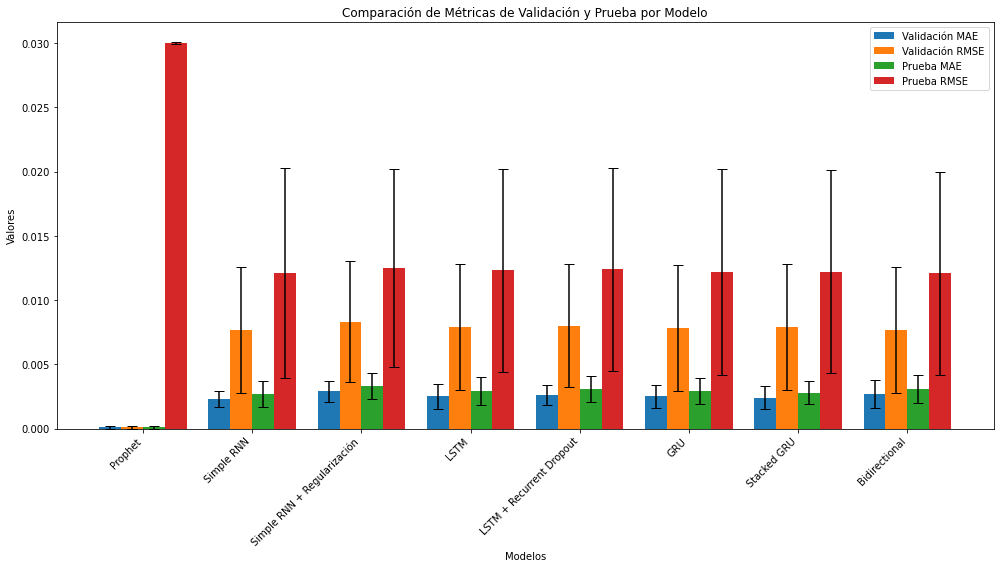

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Updated data from the Excel table
data = {
    'Modelo': [
        'Prophet',
        'Simple RNN',
        'Simple RNN + Regularización',
        'LSTM',
        'LSTM + Recurrent Dropout',
        'GRU',
        'Stacked GRU',
        'Bidirectional'
    ],
    'Validación MAE': [0.0001, 0.0023, 0.0029, 0.0025, 0.0026, 0.0025, 0.0024, 0.0027],
    'Validación MAE DE': [0.0001, 0.0006, 0.0008, 0.0010, 0.0008, 0.0009, 0.0009, 0.0011],
    'Validación RMSE': [0.0001, 0.0077, 0.0083, 0.0079, 0.0080, 0.0078, 0.0079, 0.0077],
    'Validación RMSE DE': [0.0001, 0.0049, 0.0047, 0.0049, 0.0048, 0.0049, 0.0049, 0.0049],
    'Prueba MAE': [0.0001, 0.0027, 0.0033, 0.0029, 0.0031, 0.0029, 0.0028, 0.0031],
    'Prueba MAE DE': [0.0001, 0.0010, 0.0010, 0.0011, 0.0010, 0.0010, 0.0009, 0.0011],
    'Prueba RMSE': [0.03, 0.0121, 0.0125, 0.0123, 0.0124, 0.0122, 0.0122, 0.0121],
    'Prueba RMSE DE': [0.0001, 0.0082, 0.0077, 0.0079, 0.0079, 0.0080, 0.0079, 0.0079]
}

# Create DataFrame
df = pd.DataFrame(data)

# Set figure size
fig, ax = plt.subplots(figsize=(14, 8))

# Define bar width and x-axis positions
bar_width = 0.2
index = np.arange(len(df['Modelo']))

# Plot bars for each metric
ax.bar(index - 1.5*bar_width, df['Validación MAE'], bar_width, yerr=df['Validación MAE DE'], label='Validación MAE', capsize=5)
ax.bar(index - 0.5*bar_width, df['Validación RMSE'], bar_width, yerr=df['Validación RMSE DE'], label='Validación RMSE', capsize=5)
ax.bar(index + 0.5*bar_width, df['Prueba MAE'], bar_width, yerr=df['Prueba MAE DE'], label='Prueba MAE', capsize=5)
ax.bar(index + 1.5*bar_width, df['Prueba RMSE'], bar_width, yerr=df['Prueba RMSE DE'], label='Prueba RMSE', capsize=5)

# Labels and title
ax.set_xlabel('Modelos')
ax.set_ylabel('Valores')
ax.set_title('Comparación de Métricas de Validación y Prueba por Modelo')
ax.set_xticks(index)
ax.set_xticklabels(df['Modelo'], rotation=45, ha='right')
ax.legend()

# Adjust layout and show graph
plt.tight_layout()
plt.show()



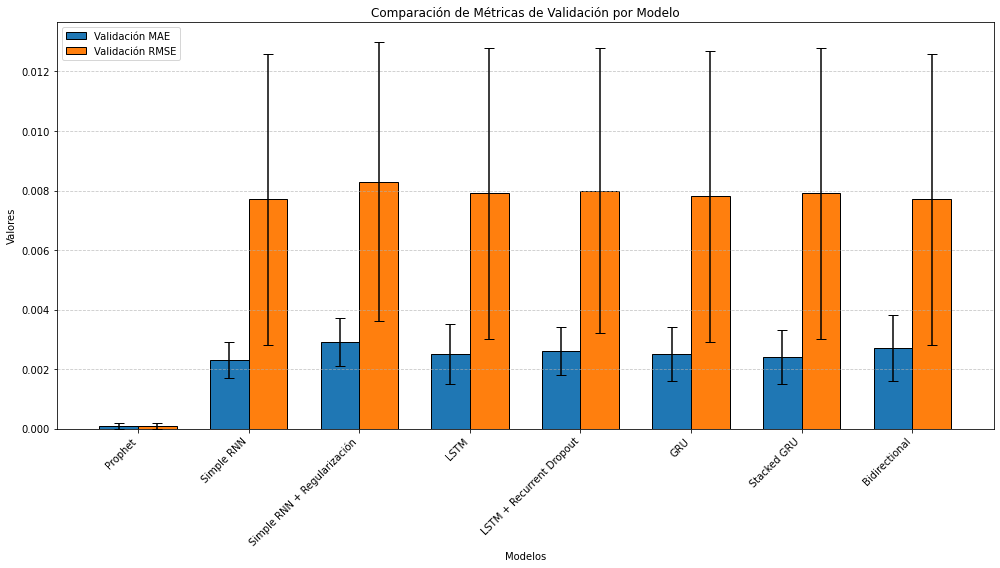

In [63]:
# Updated data from the Excel table for validation metrics only
data_validation = {
    'Modelo': [
        'Prophet',
        'Simple RNN',
        'Simple RNN + Regularización',
        'LSTM',
        'LSTM + Recurrent Dropout',
        'GRU',
        'Stacked GRU',
        'Bidirectional'
    ],
    'Validación MAE': [0.0001, 0.0023, 0.0029, 0.0025, 0.0026, 0.0025, 0.0024, 0.0027],
    'Validación MAE DE': [0.0001, 0.0006, 0.0008, 0.0010, 0.0008, 0.0009, 0.0009, 0.0011],
    'Validación RMSE': [0.0001, 0.0077, 0.0083, 0.0079, 0.0080, 0.0078, 0.0079, 0.0077],
    'Validación RMSE DE': [0.0001, 0.0049, 0.0047, 0.0049, 0.0048, 0.0049, 0.0049, 0.0049]
}

# Create DataFrame
df_validation = pd.DataFrame(data_validation)

# Set figure size
fig, ax = plt.subplots(figsize=(14, 8))

# Define bar width and x-axis positions
bar_width = 0.35
index = np.arange(len(df_validation['Modelo']))

# Plot bars for Validation MAE and Validation RMSE with error bars
ax.bar(index - bar_width/2, df_validation['Validación MAE'], bar_width, 
       yerr=df_validation['Validación MAE DE'], label='Validación MAE', capsize=5, edgecolor='black')
ax.bar(index + bar_width/2, df_validation['Validación RMSE'], bar_width, 
       yerr=df_validation['Validación RMSE DE'], label='Validación RMSE', capsize=5, edgecolor='black')

# Labels and title
ax.set_xlabel('Modelos')
ax.set_ylabel('Valores')
ax.set_title('Comparación de Métricas de Validación por Modelo')
ax.set_xticks(index)
ax.set_xticklabels(df_validation['Modelo'], rotation=45, ha='right')
ax.legend()

# Add grid lines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show graph
plt.tight_layout()
plt.show()


# Compare Time Series Model Prophet vs Neural Network

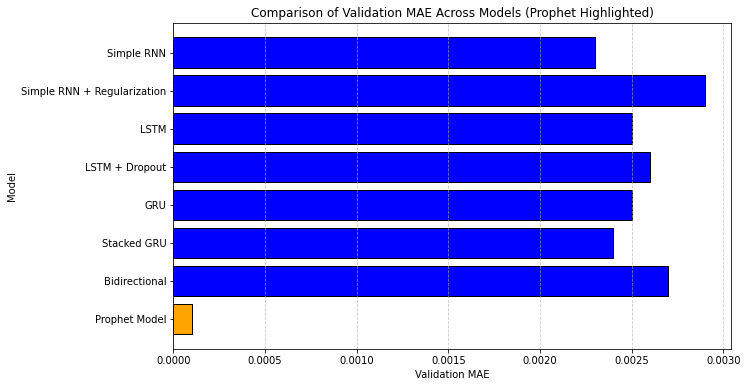

In [64]:
import matplotlib.pyplot as plt

# Updated validation MAE values including Prophet
validacion_results_with_prophet = {
    "Simple RNN": 0.0023,
    "Simple RNN + Regularization": 0.0029,
    "LSTM": 0.0025,
    "LSTM + Dropout": 0.0026,
    "GRU": 0.0025,
    "Stacked GRU": 0.0024,
    "Bidirectional": 0.0027,
    "Prophet Model": 0.0001  # Prophet highlighted separately
}

# Configure colors, highlighting Prophet model
colors = ['blue'] * (len(validacion_results_with_prophet) - 1) + ['orange']

# Create the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(list(validacion_results_with_prophet.keys()), list(validacion_results_with_prophet.values()), 
         color=colors, edgecolor='black')

# Labels and title
plt.xlabel("Validation MAE")
plt.ylabel("Model")
plt.title("Comparison of Validation MAE Across Models (Prophet Highlighted)")

# Invert Y-axis for readability
plt.gca().invert_yaxis()

# Add grid lines for better reference
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()



The graph shows that Prophet has the lowest validation MAE, indicating significantly superior performance compared to recurrent neural network architectures (RNN, LSTM, and GRU). While deep learning models exhibit higher errors with minimal differences among them, Prophet achieves an almost zero error, suggesting it is the most accurate and reliable option for this forecasting task. This highlights Prophet's effectiveness in time series prediction, outperforming more complex models without the need for additional tuning. May bye could improve the task appling grid search in both cases.